## Assignment 9: Supervised Learning Using H2o GBM, AutoML & Deep Learning Modules

The goal is to create model to identify loans potential for default. We will get a general understanding of the dataset and create relevant features that can be used later for efficient modeling. For this particular case we will aggregate the data to the loan_default level and card holder level then build various features.

## Data description
A Columbia partner firm has made its loans dataset available for research. The dataset contains 86 attributes with 80000 records.The data we are going to work on is the mortgage default dataset.The field 'loan_default' is the target variable. 

The objective of this problem is to predict loan default on the test set and present evaluation metrics such as ROC, Lift and Precision-Recall Curve. Cumulative lift is compared for different models from the gains chart and AUC(Area under curve) is measured for ROC curve and P-R curve. The models deployed are H2o's Gradient Boosting Machine & Deep Learning. Ensemle learning works best in cases where Type 1 and Type 2 errors render to be costly.

This assignment has the following components:
* Load and Clean the dataset
* Create and select essential features. Variable importance using the GBM Estimator gives us an idea of what variables to keep
* Testing the model on predefined hyperparameters
* Fine tune parameters by performing grid search and then re-running the model with the best parameters

In [1]:
import numpy as np
import plotly
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_f = pd.read_csv("XYZloan_default_selected_vars.csv")

In [3]:
data_f.dtypes

Unnamed: 0        int64
Unnamed: 0.1      int64
id                int64
loan_default      int64
AP001             int64
                 ...   
CD170           float64
CD172           float64
CD173           float64
MB005           float64
MB007            object
Length: 89, dtype: object

In [4]:
data_f['MB007'].unique()

array(['IPHONE7', 'WEB', 'OPPO', 'IPHONE8', 'IPHONE9', 'Noinfo', 'HUAWEI',
       'XIAOMI', 'GIONEE', 'VIVO', 'MEIZU', 'IPHONE6', 'IPHONE5', 'LEECO',
       'HONOR', 'SAMSUNG', '360', 'LETV', 'NUBIA', 'COOLPAD', 'IPAD4',
       'ZTE', 'IPAD6', 'IPHONE4', 'MEITU', 'ONEPLUS', 'LENOVO', 'IPAD3',
       'QIKU', 'LGE', 'PROTRULY', 'IPAD5', 'ZUK', 'DOOV', 'HISENSE',
       'SMARTISAN', 'XIAOLAJIAO', 'YUFLY', 'GOOGLE', 'CMDC', 'HTC', 'AND',
       'AMOI', 'KOPO', 'IVVI', 'NOKIA', 'YEPEN', 'SUGAR', 'SONY', 'ALPS',
       'CMCC', 'MANN', 'CHANGHONG', 'DAQ', 'IPOD7', 'PHILIPS', 'MOTOROLA',
       'ASUS', 'IPAD2', 'KOOBEE', 'SKYHON', 'SM-W2016', 'OWWO', 'VERIZON',
       '4G', 'MYTEL', 'YU-FLY', 'FOPAD', 'UOOGOU', 'SGMSGMS', 'KONKA',
       'BIFER', 'IPHONE3', 'TCL', 'GO', 'CHINAMOBILE', 'KINGSUN', 'KDDI',
       'ANDROID', 'ZUOKU', 'HMI', 'MLLED', 'HONGLAJIAO', 'VEGA', 'BIRD',
       'LINGWIN', 'TINAI', 'APPLE', 'VETAS', 'VOLTE', 'LEPHONE', 'REDGOO',
       'RAMOS', 'CONGMETAL', 'YTONE_L985', 'B

In [5]:
data_f['AP006'].unique()

array(['ios', 'h5', 'android', 'api'], dtype=object)

### Handling non-numeric data

In [6]:
obj = data_f.select_dtypes(include = ['object'])
obj.head(2)

,AP005,AP006,MB007
0,2017/7/6 10:21,ios,IPHONE7
1,2017/4/6 12:51,h5,WEB


In [7]:
obj["AP005"] =  pd.to_datetime(obj["AP005"])
obj['hour'] = obj['AP005'].dt.hour
obj['dayofweek'] = obj['AP005'].dt.dayofweek
obj['day'] = obj['AP005'].dt.day
obj['month'] = obj['AP005'].dt.month
obj['year'] = obj['AP005'].dt.year

<ipython-input-7-a41470806554>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj["AP005"] =  pd.to_datetime(obj["AP005"])
<ipython-input-7-a41470806554>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj['hour'] = obj['AP005'].dt.hour
<ipython-input-7-a41470806554>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [8]:
obj = obj.iloc[:,[3,4,5,6]]

In [9]:
obj

,hour,dayofweek,day,month
0,10,3,6,7
1,12,3,6,4
2,14,5,1,7
3,10,4,7,7
4,14,3,6,7
...,...,...,...,...
79995,13,6,7,5
79996,15,4,2,6
79997,8,6,9,7
79998,10,1,9,5


In [10]:
#obj = pd.get_dummies(obj)
#obj = obj[obj.columns[1:]]

In [11]:
df1 = pd.concat([data_f,obj],axis = 1)
df1.head(2)

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD169,CD170,CD172,CD173,MB005,MB007,hour,dayofweek,day,month
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,...,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7,10,3,6,7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,...,-99.0,-99.0,-99.0,-99.0,NaN,WEB,12,3,6,4


In [12]:
features = ['loan_default','AP001','AP002','AP003','AP004','AP007','AP008','AP009','TD001','TD002','TD005','TD006','TD009','TD010','TD013','TD014','TD015','TD022','TD023','TD024','TD025','TD026','TD027','TD028','TD029','CR004','CR005','CR009','CR012','CR015','CR017','CR018','CR019','PA022','PA023','PA028','PA029','PA030','PA031','CD008','CD018','CD071','CD072','CD088','CD100','CD101','CD106','CD107','CD108','CD113','CD114','CD115','CD117','CD118','CD120','CD121','CD123','CD130','CD131','CD132','CD133','CD135','CD136','CD137','CD152','CD153','CD160','CD162','CD164','CD166','CD167','CD169','CD170','CD172','CD173','MB005','hour','dayofweek','day','month']
df = df1[features]

#### Check for missing values

In [13]:
missing_values = df.isnull().sum()
missing_values_per = (df.isnull().sum() / df.isnull().count())
pd.concat([missing_values, missing_values_per],axis=1, keys = ['Count_of_Missing','Percentage'])

,Count_of_Missing,Percentage
loan_default,0,0.000000
AP001,0,0.000000
AP002,0,0.000000
AP003,0,0.000000
AP004,0,0.000000
...,...,...
MB005,2793,0.034912
hour,0,0.000000
dayofweek,0,0.000000
day,0,0.000000


#### Filling in missing data

In [14]:
for col in features:
    df.loc[:,col].fillna(df.loc[:,col].mean(),inplace=True)

c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## Section 2: Weight of Evidence (WOE) ENCODING
##### Weight of evidence (WOE) is a widely used technique in credit risk modeling or called the probability of default modeling (such models predict how capable an applicant is able to repay the loan).

The goal of such transformation is to get the maximum difference among the binned categories relating to the target variable. It counts the number of responders and non-responders in each binned categories, then assigns a numeric value to each of the binned categories. 

In [15]:
def WOE(var):
    try:
        df[var] = df[var].fillna('NoData')
    except:
        pass
    k = df[[var,'loan_default']].groupby(var)['loan_default'].agg(['count','sum']).reset_index()
    k.columns = [var,'Count','Bad']
    k['Good'] = k['Count'] - k['Bad']
    k['Good %'] = (k['Good'] / k['Good'].sum()*100).round(2)
    k['Bad %'] = (k['Bad'] / k['Bad'].sum()*100).round(2)
    ratio = k['Good %'] / k['Bad %']
    k[var+'_WOE'] = np.log(ratio).round(2)
    k = k.sort_values(by=var+'_WOE')
    return(k)

In [16]:
for i in features[1:]:
    var = i
    binned_var = var + '_D'
    percentile = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
    df[binned_var] = pd.qcut( df[var],percentile,duplicates='drop')

<ipython-input-16-c5aca2ea478b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[binned_var] = pd.qcut( df[var],percentile,duplicates='drop')
<ipython-input-16-c5aca2ea478b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[binned_var] = pd.qcut( df[var],percentile,duplicates='drop')
<ipython-input-16-c5aca2ea478b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [17]:
features1 = ['AP001_D','AP002_D','AP003_D','AP004_D','AP007_D','AP008_D','AP009_D','TD001_D','TD002_D','TD005_D','TD006_D','TD009_D','TD010_D','TD013_D','TD014_D','TD015_D','TD022_D','TD023_D','TD024_D','TD025_D','TD026_D','TD027_D','TD028_D','TD029_D','CR004_D','CR005_D','CR009_D','CR012_D','CR015_D','CR017_D','CR018_D','CR019_D','PA022_D','PA023_D','PA028_D','PA029_D','PA030_D','PA031_D','CD008_D','CD018_D','CD071_D','CD072_D','CD088_D','CD100_D','CD101_D','CD106_D','CD107_D','CD108_D','CD113_D','CD114_D','CD115_D','CD117_D','CD118_D','CD120_D','CD121_D','CD123_D','CD130_D','CD131_D','CD132_D','CD133_D','CD135_D','CD136_D','CD137_D','CD152_D','CD153_D','CD160_D','CD162_D','CD164_D','CD166_D','CD167_D','CD169_D','CD170_D','CD172_D','CD173_D','MB005_D','hour','dayofweek','day','month']

<ipython-input-18-4dd47e55297f>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


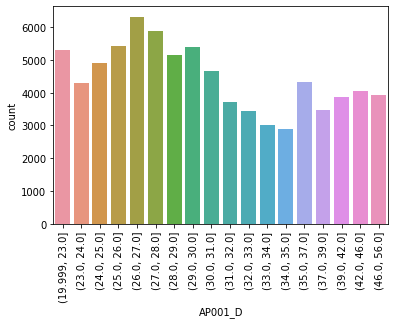

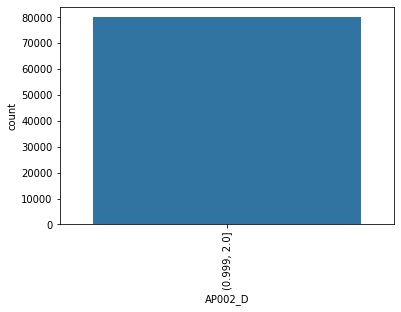

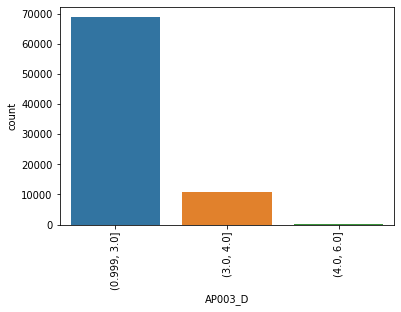

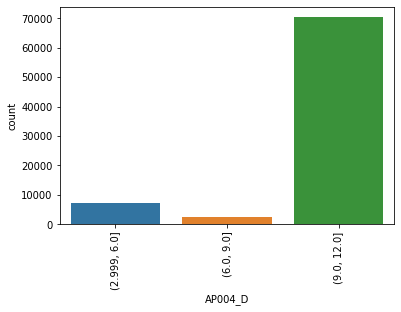

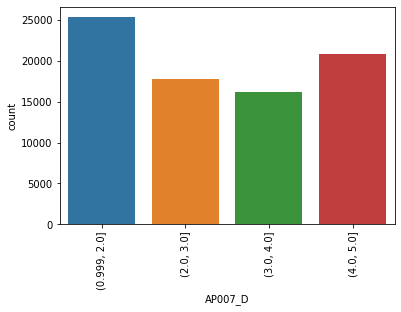

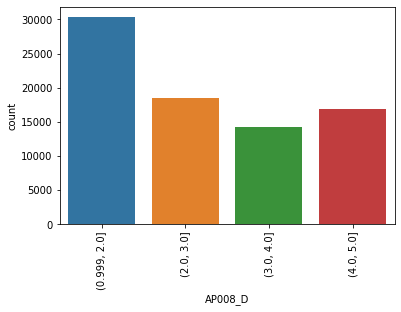

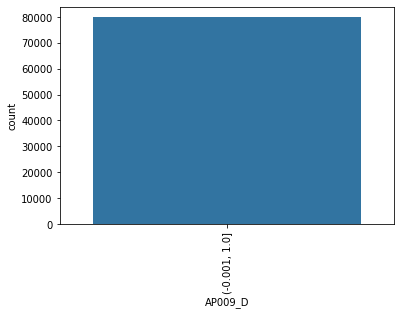

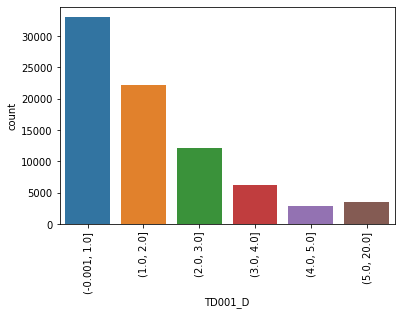

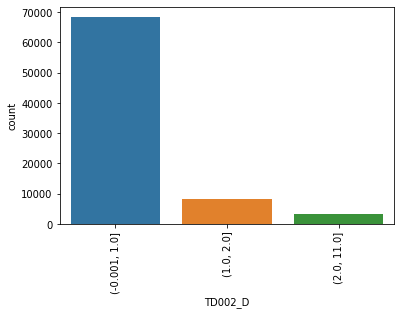

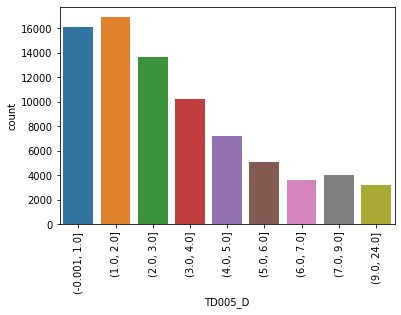

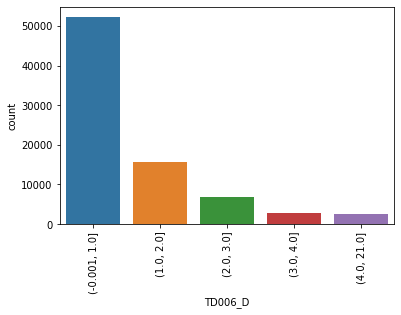

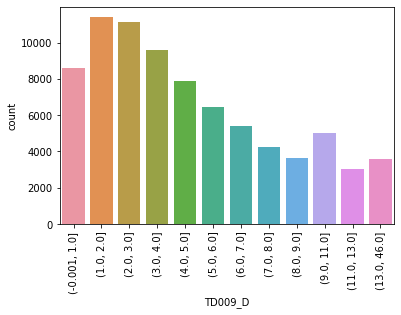

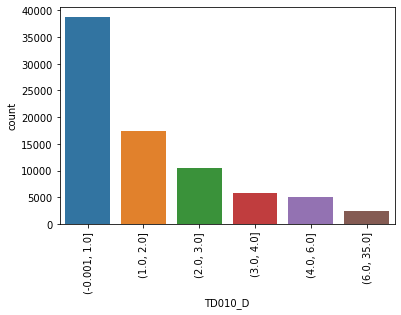

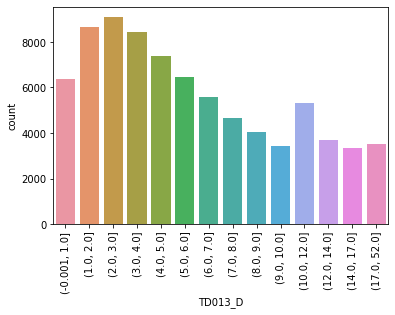

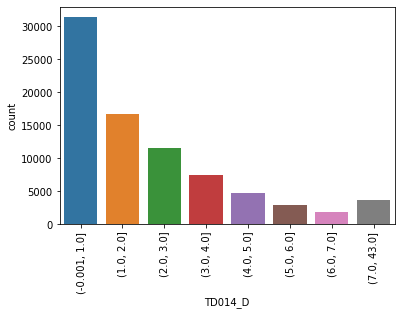

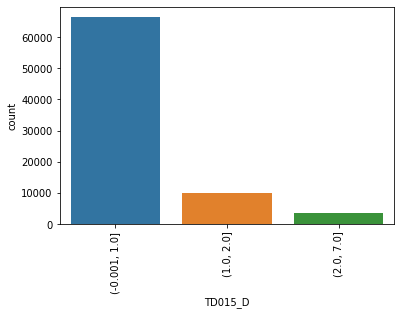

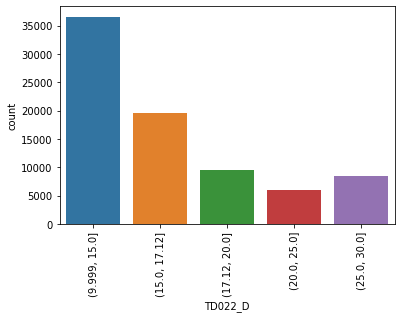

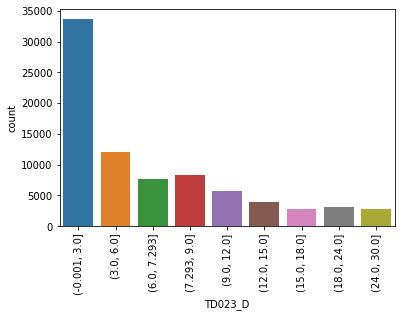

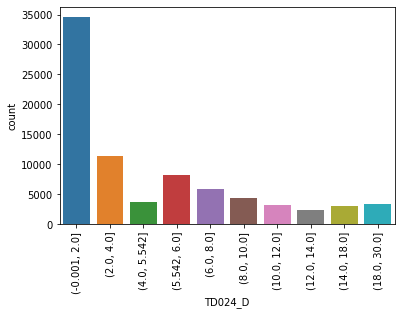

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

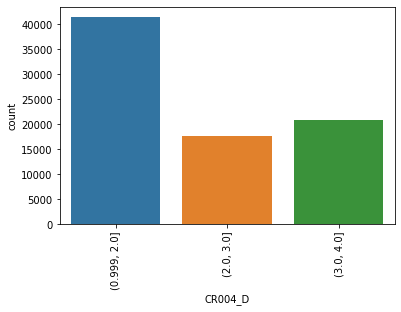

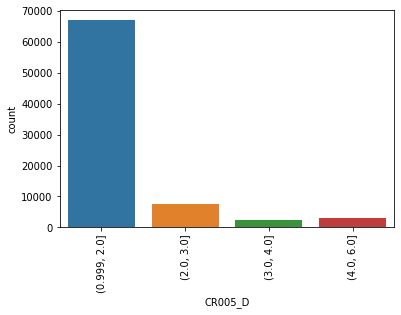

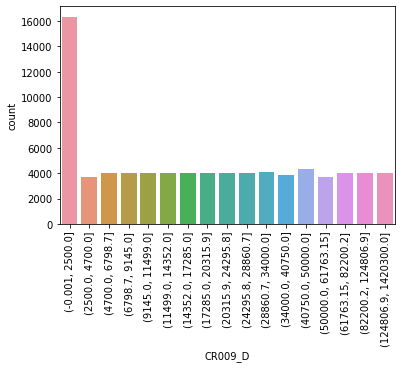

<Figure size 432x288 with 0 Axes>

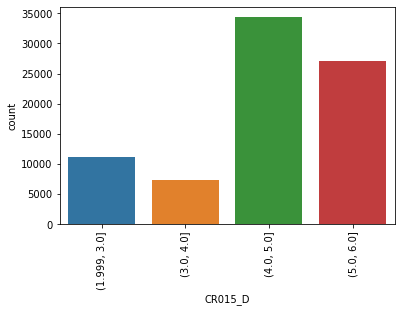

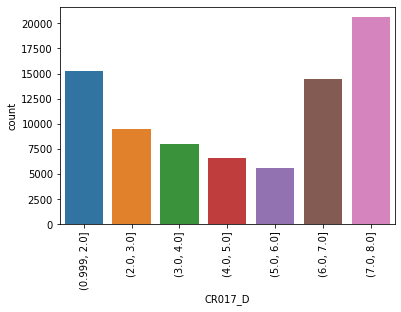

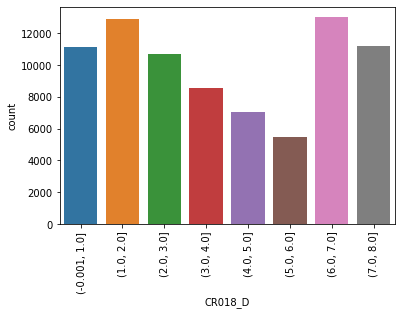

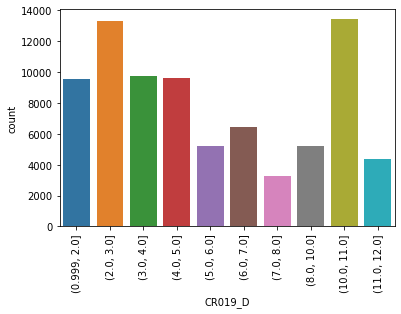

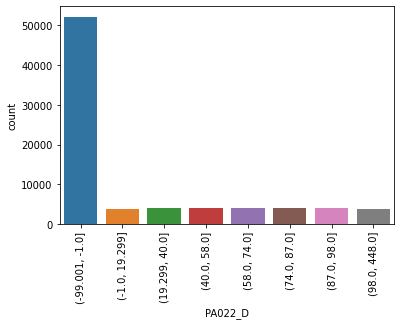

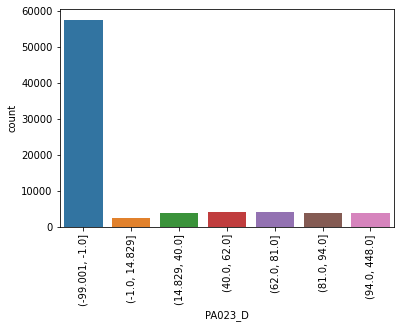

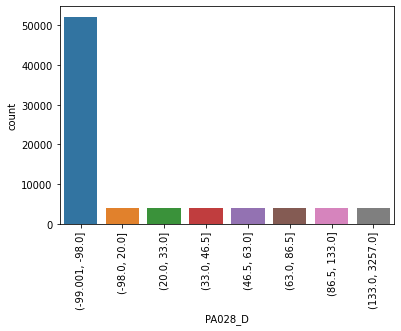

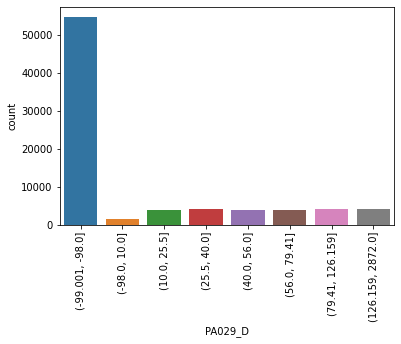

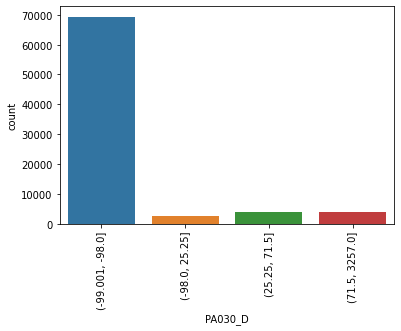

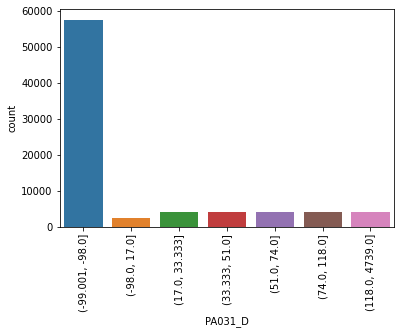

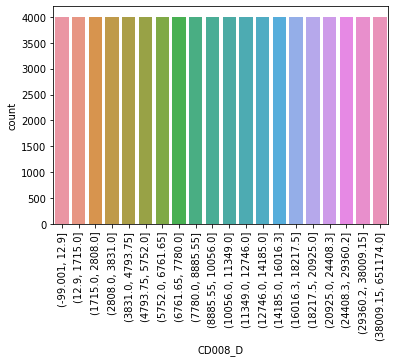

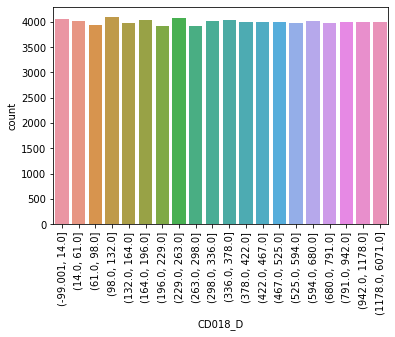

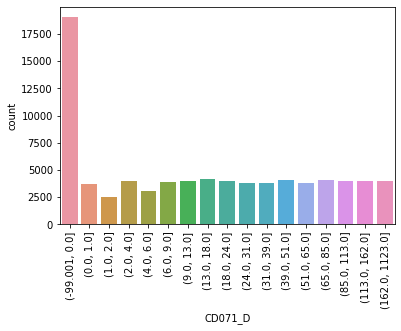

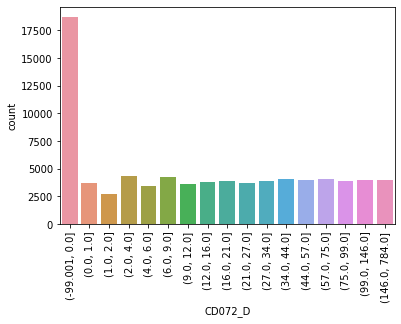

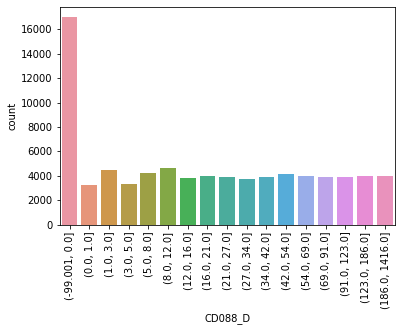

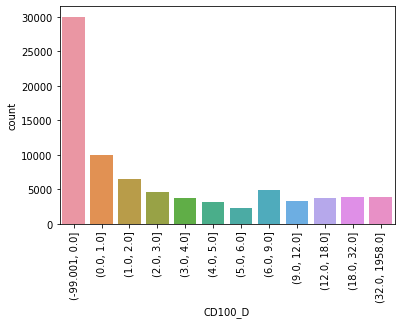

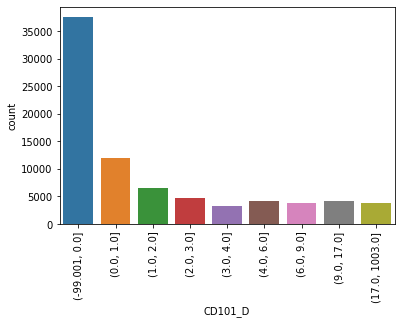

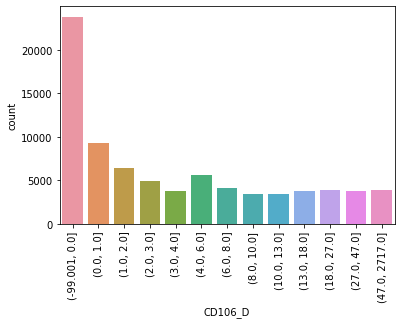

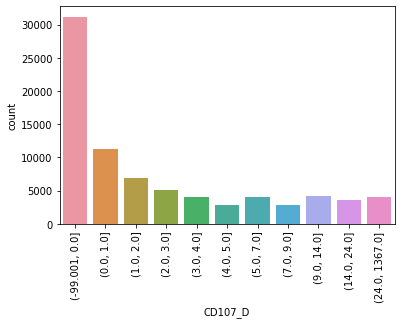

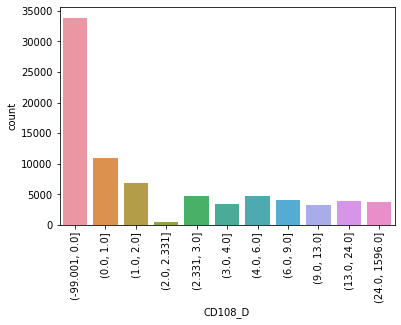

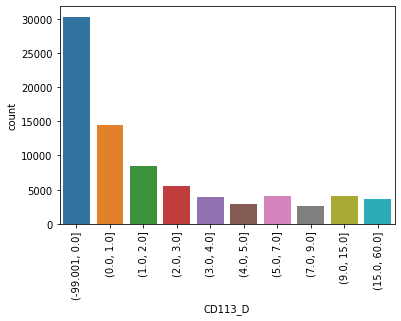

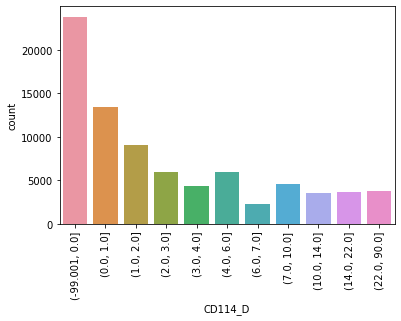

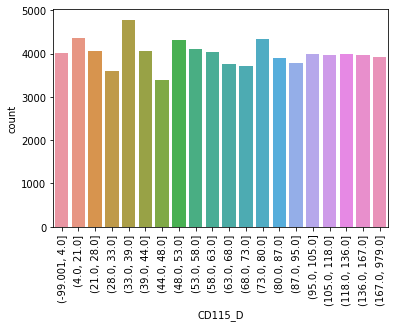

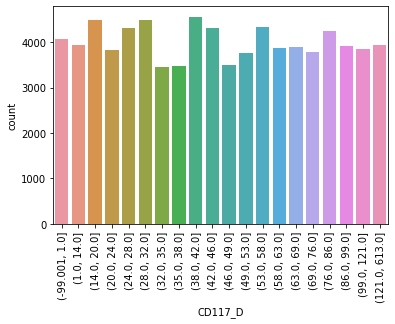

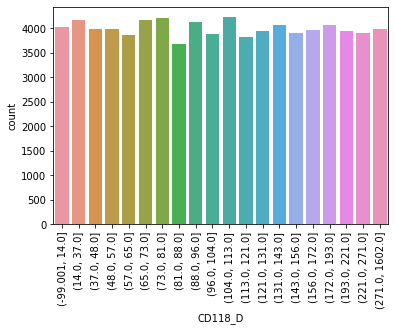

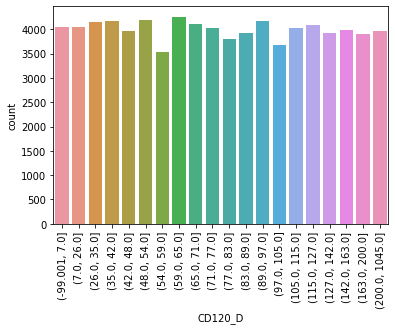

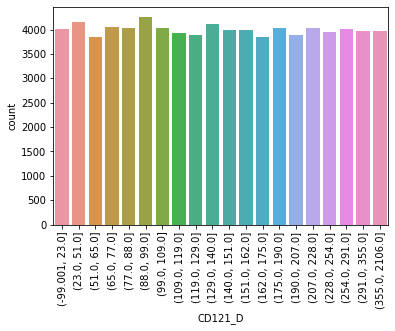

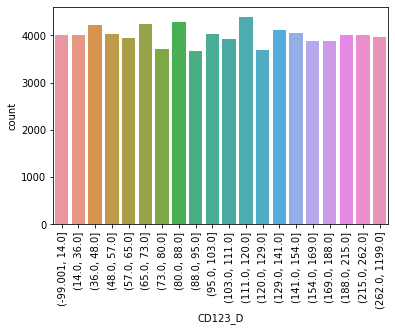

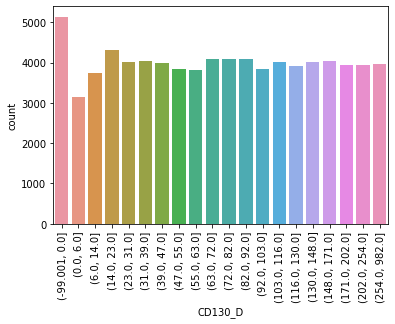

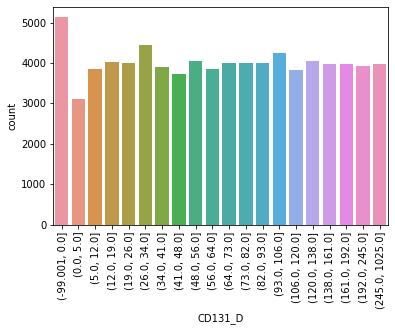

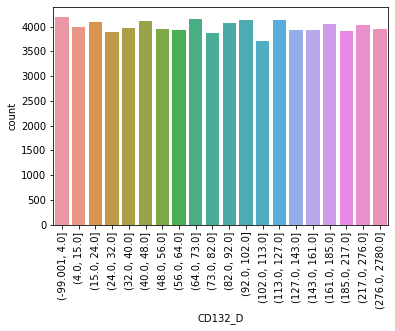

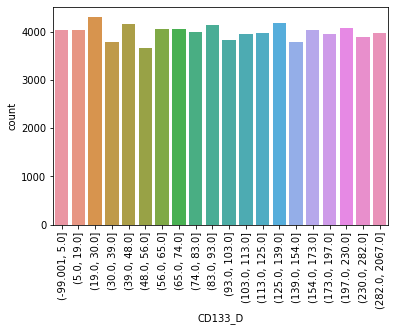

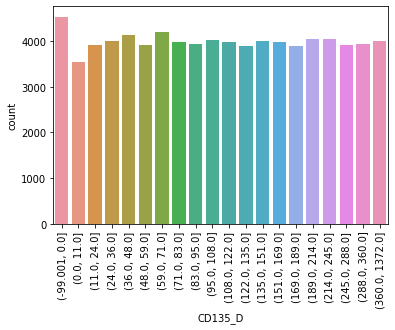

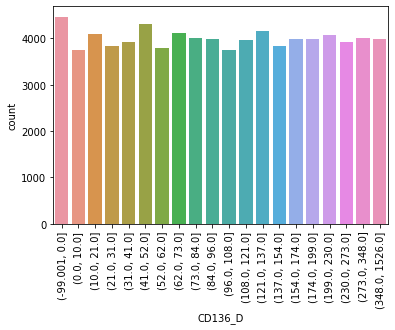

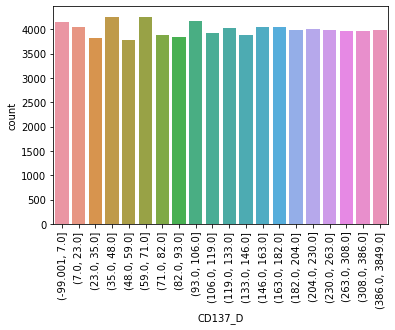

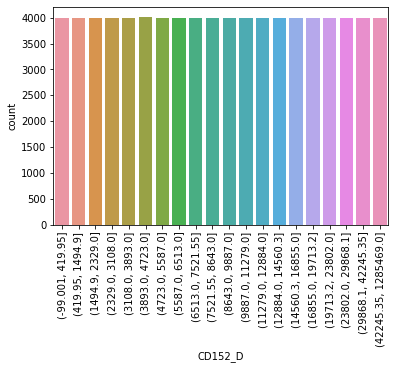

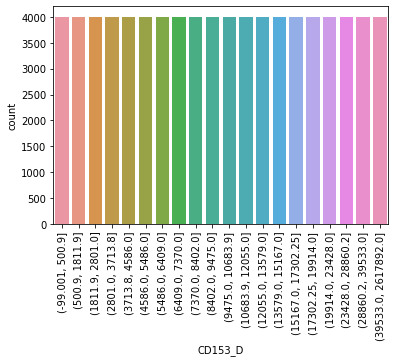

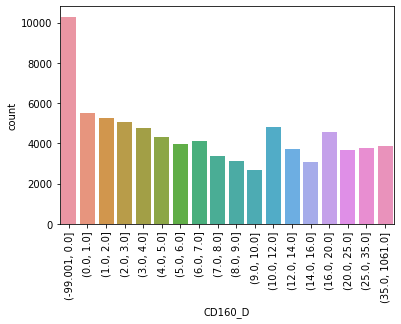

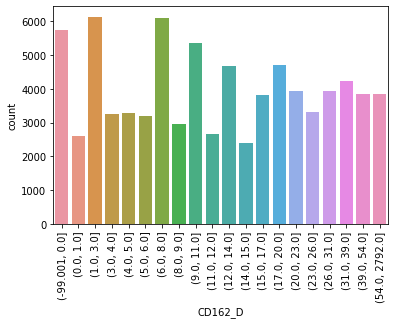

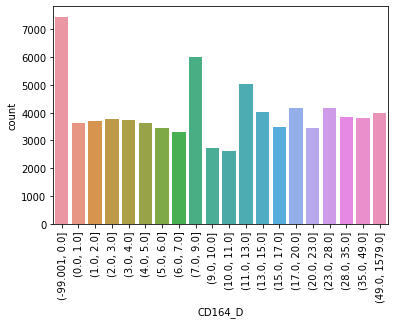

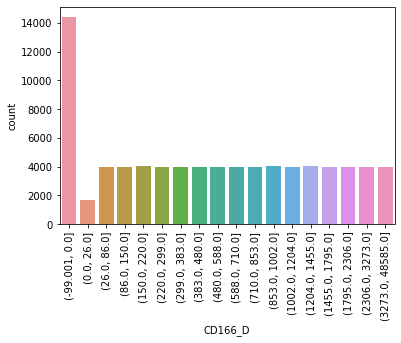

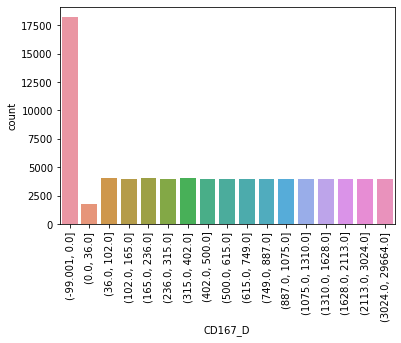

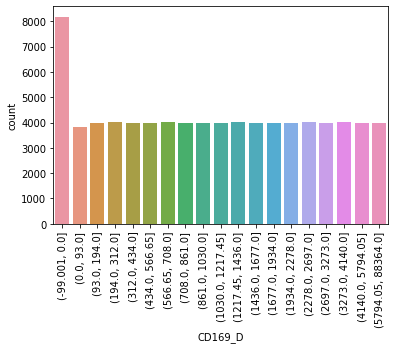

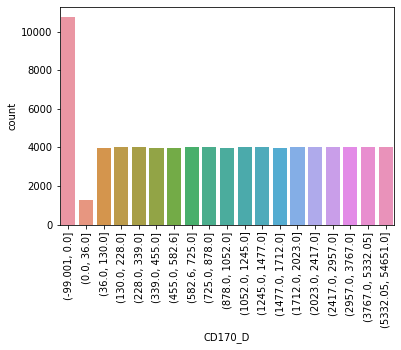

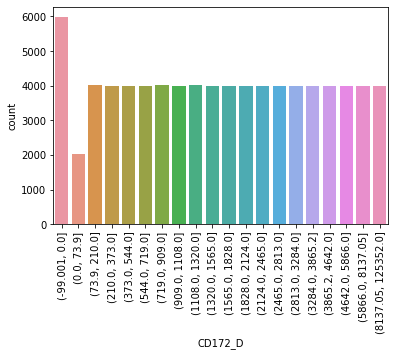

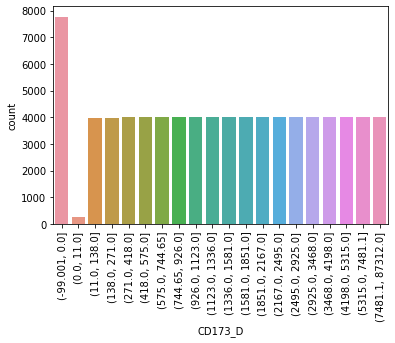

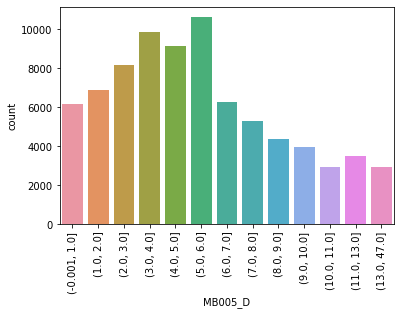

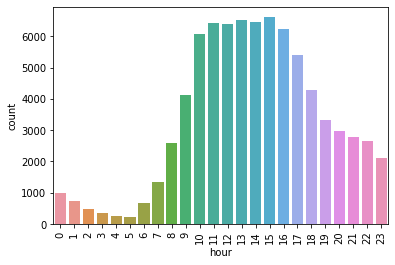

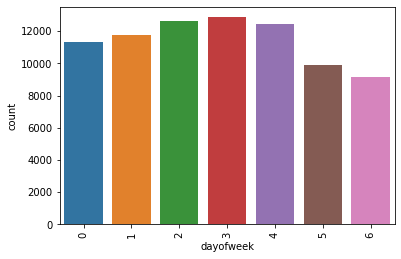

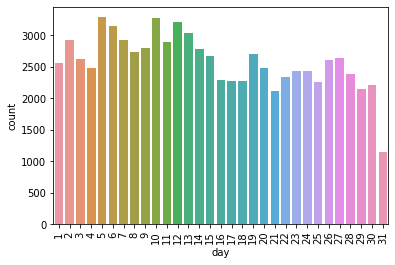

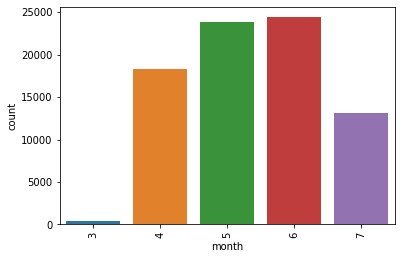

In [18]:
for i in features1:
    try:
        plt.figure(figsize=(6,4))
        g = sns.countplot(x=i, data=df)
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
    except:
        pass

### Passing the Bins attributes to WOE function to create respective weights

In [19]:
for f in features1:
    try:
        k = WOE(f)
        df = pd.merge(df,k[[f,f+'_WOE']], left_on=f, right_on=f,how='left')
    except:
        pass

In [20]:
df.describe()

,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,AP009,TD001,TD002,...,CD167_D_WOE,CD169_D_WOE,CD170_D_WOE,CD172_D_WOE,CD173_D_WOE,MB005_D_WOE,hour_WOE,dayofweek_WOE,day_WOE,month_WOE
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,...,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.193600,31.706913,1.321813,2.014925,11.235413,3.30130,3.117200,0.727925,1.986962,0.706213,...,0.000571,0.003320,0.002369,0.002508,0.00267,0.010630,0.000217,-0.000353,0.000532,0.002163
std,0.395121,7.075070,0.467174,1.196806,2.212313,1.33655,1.306335,0.445031,1.807445,0.918347,...,0.082500,0.099453,0.103636,0.098480,0.09896,0.182356,0.061067,0.023721,0.063353,0.086492
min,0.000000,20.000000,1.000000,1.000000,3.000000,1.00000,1.000000,0.000000,0.000000,0.000000,...,-0.200000,-0.190000,-0.190000,-0.160000,-0.17000,-0.270000,-0.410000,-0.040000,-0.200000,-0.100000
25%,0.000000,27.000000,1.000000,1.000000,12.000000,2.00000,2.000000,0.000000,1.000000,0.000000,...,-0.030000,-0.070000,-0.080000,-0.080000,-0.07000,-0.160000,-0.020000,0.000000,-0.030000,-0.050000
50%,0.000000,30.000000,1.000000,1.000000,12.000000,3.00000,3.000000,1.000000,2.000000,0.000000,...,-0.010000,0.010000,0.000000,0.020000,0.02000,-0.010000,-0.010000,-0.000000,-0.000000,-0.050000
75%,0.000000,35.000000,2.000000,3.000000,12.000000,5.00000,4.000000,1.000000,3.000000,1.000000,...,0.090000,0.100000,0.080000,0.080000,0.07000,0.080000,0.020000,0.010000,0.040000,0.050000
max,1.000000,56.000000,2.000000,6.000000,12.000000,5.00000,5.000000,1.000000,20.000000,11.000000,...,0.100000,0.150000,0.160000,0.170000,0.17000,0.490000,0.160000,0.040000,0.130000,0.150000


In [21]:
features2 = ['AP001_D_WOE','AP002_D_WOE','AP003_D_WOE','AP004_D_WOE','AP007_D_WOE','AP008_D_WOE','AP009_D_WOE','TD001_D_WOE','TD002_D_WOE','TD005_D_WOE','TD006_D_WOE','TD009_D_WOE','TD010_D_WOE','TD013_D_WOE','TD014_D_WOE','TD015_D_WOE','TD022_D_WOE','TD023_D_WOE','TD024_D_WOE','TD025_D_WOE','TD026_D_WOE','TD027_D_WOE','TD028_D_WOE','TD029_D_WOE','CR004_D_WOE','CR005_D_WOE','CR009_D_WOE','CR012_D_WOE','CR015_D_WOE','CR017_D_WOE','CR018_D_WOE','CR019_D_WOE','PA022_D_WOE','PA023_D_WOE','PA028_D_WOE','PA029_D_WOE','PA030_D_WOE','PA031_D_WOE','CD008_D_WOE','CD018_D_WOE','CD071_D_WOE','CD072_D_WOE','CD088_D_WOE','CD100_D_WOE','CD101_D_WOE','CD106_D_WOE','CD107_D_WOE','CD108_D_WOE','CD113_D_WOE','CD114_D_WOE','CD115_D_WOE','CD117_D_WOE','CD118_D_WOE','CD120_D_WOE','CD121_D_WOE','CD123_D_WOE','CD130_D_WOE','CD131_D_WOE','CD132_D_WOE','CD133_D_WOE','CD135_D_WOE','CD136_D_WOE','CD137_D_WOE','CD152_D_WOE','CD153_D_WOE','CD160_D_WOE','CD162_D_WOE','CD164_D_WOE','CD166_D_WOE','CD167_D_WOE','CD169_D_WOE','CD170_D_WOE','CD172_D_WOE','CD173_D_WOE','MB005_D_WOE','hour_WOE','dayofweek_WOE','day_WOE','month_WOE']

### Importing H2O

In [22]:
#importing h20 and intiating
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.12+8-LTS-237, mixed mode)
  Starting server from C:\Users\Varadharajan Suresh\AppData\Local\Programs\Python\Python39\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\VARADH~1\AppData\Local\Temp\tmpsvumgqqh
  JVM stdout: C:\Users\VARADH~1\AppData\Local\Temp\tmpsvumgqqh\h2o_Varadharajan_Suresh_started_from_python.out
  JVM stderr: C:\Users\VARADH~1\AppData\Local\Temp\tmpsvumgqqh\h2o_Varadharajan_Suresh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 26 days
H2O_cluster_name:,H2O_from_python_Varadharajan_Suresh_0zhiz0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.938 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [23]:
#importing h2o estimators gradient boosting and other packages
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from sklearn.model_selection import train_test_split

In [24]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

In [25]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

In [26]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

## GLM
A generalized linear model (GLM) is a flexible generalization of ordinary linear regression. The GLM generalizes linear regression by allowing the linear model to be related to the response variable via a link function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value.

GLM fits a generalized linear model, specified by a response variable, a set of predictors, and a description of the error distribution.

A subclass of ModelBase is returned. The specific subclass depends on the machine learning task at hand (if it’s binomial classification, then an H2OBinomialModel is returned, if it’s regression then a H2ORegressionModel is returned). The default print-out of the models is shown, but further GLM-specific information can be queried out of the object. Upon completion of the GLM, the resulting object has coefficients, normalized coefficients, residual/null deviance, aic, and a host of model metrics including MSE, AUC (for logistic regression), degrees of freedom, and confusion matrices.

In [27]:
#import h20 estimator for GLM
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [32]:
train, test = train_test_split(df, test_size=0.40, random_state=414)

### Model 0: using all the raw features 10% of data

In [354]:
target = 'loan_default'
predictors = ['AP001','AP002','AP003','AP004','AP007','AP008','AP009','TD001','TD002','TD005','TD006','TD009','TD010','TD013','TD014','TD015','TD022','TD023','TD024','TD025','TD026','TD027','TD028','TD029','CR004','CR005','CR009','CR012','CR015','CR017','CR018','CR019','PA022','PA023','PA028','PA029','PA030','PA031','CD008','CD018','CD071','CD072','CD088','CD100','CD101','CD106','CD107','CD108','CD113','CD114','CD115','CD117','CD118','CD120','CD121','CD123','CD130','CD131','CD132','CD133','CD135','CD136','CD137','CD152','CD153','CD160','CD162','CD164','CD166','CD167','CD169','CD170','CD172','CD173','MB005','hour','dayofweek','day','month']

In [355]:
train_smpl = train.sample(frac=0.2, random_state=1)
test_smpl = test.sample(frac=0.2, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [356]:
glm_v0 = H2OGeneralizedLinearEstimator(family= "AUTO",lambda_ = 0.05)
glm_v0.train(predictors,target,training_frame=train_hex)

glm Model Build progress: |

c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\h2o\estimators\estimator_base.py:206: RuntimeWarning: Dropping bad and constant columns: [TD029, TD028, TD027, TD026, TD025, CR012]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1638595506565_127


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 0.05 )",73,6,3,Key_Frame__upload_b97067a45b1ab80e797215a76c084c89.hex




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.15109776354494017
RMSE: 0.3887129577785389
MAE: 0.30554566695644114
RMSLE: 0.2721774380396855
R^2: 0.030751435963263907
Mean Residual Deviance: 0.15109776354494017
Null degrees of freedom: 9599
Residual degrees of freedom: 9593
Null deviance: 1496.5598958333844
Residual deviance: 1450.5385300314256
AIC: 9117.269012202829

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,training_rmse,training_deviance,training_mae,training_r2
0,,2021-12-04 18:03:34,0.000 sec,0,1496.559896,0.155892,,,,
1,,2021-12-04 18:03:34,0.009 sec,3,,,0.388713,0.151098,0.305546,0.030751



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,AP004,0.021596,1.000000,0.327121
1,TD009,0.015664,0.725300,0.237261
2,TD005,0.010741,0.497379,0.162703
3,AP003,0.009201,0.426068,0.139376
4,TD013,0.008461,0.391787,0.128162
5,TD010,0.000355,0.016435,0.005376
6,AP001,0.000000,0.000000,0.000000
7,AP002,0.000000,0.000000,0.000000
8,AP007,0.000000,0.000000,0.000000
9,AP008,0.000000,0.000000,0.000000



See the whole table with table.as_data_frame()


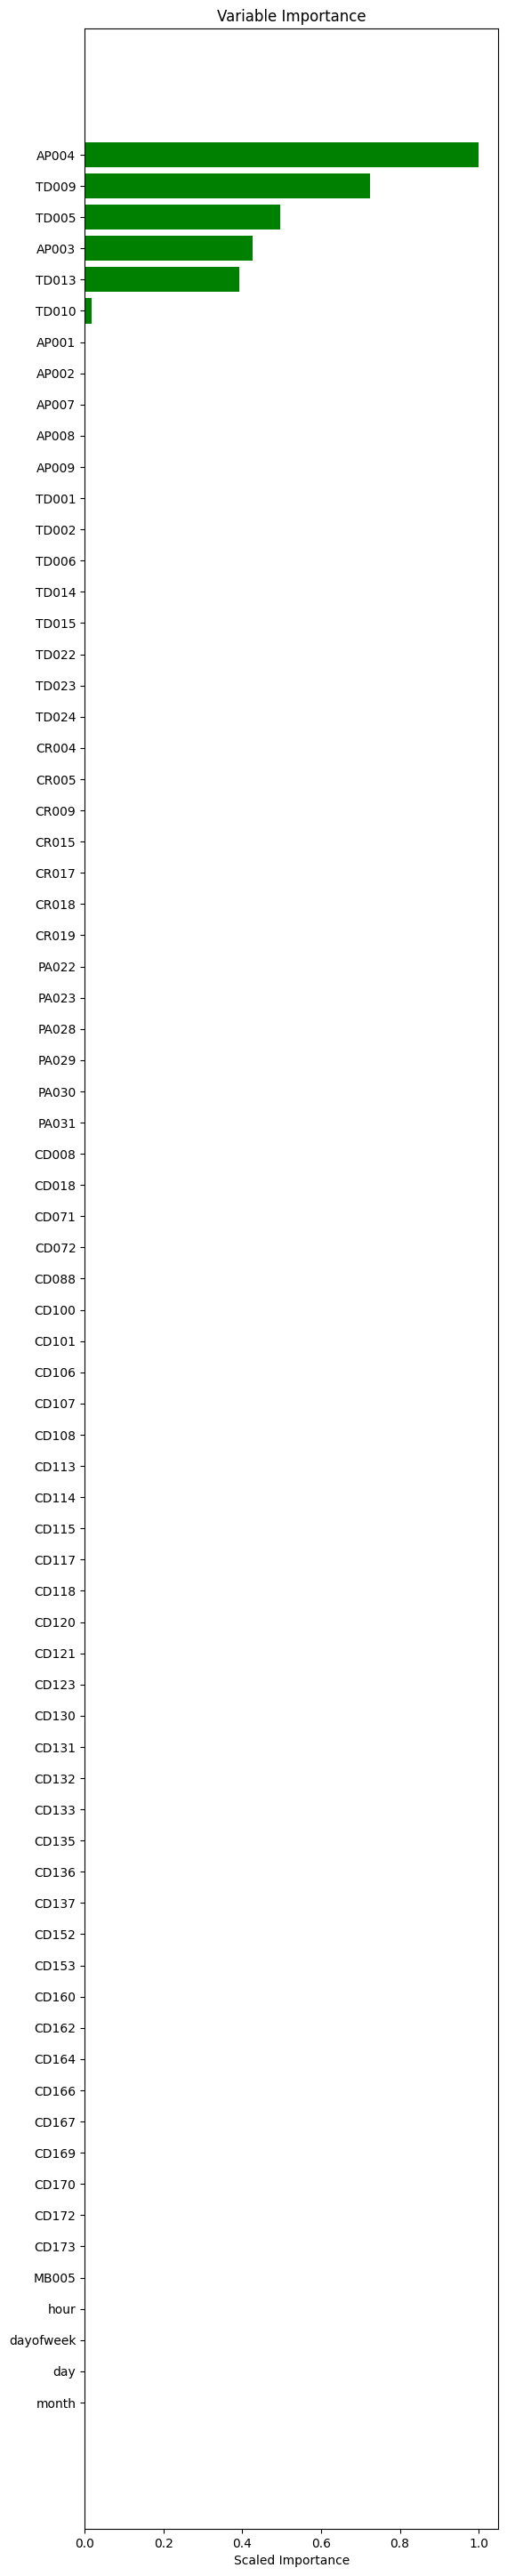

In [357]:
VarImp(glm_v0)

In [358]:
createGains(glm_v0)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,640,226,414,640,226,414,0.18,0.08,122.3,1.85,10.0,35.31
1,640,187,453,1280,413,867,0.34,0.17,244.6,1.69,17.0,32.27
2,640,145,495,1920,558,1362,0.46,0.26,366.9,1.52,20.0,29.06
3,640,139,501,2560,697,1863,0.57,0.36,489.2,1.42,21.0,27.23
4,640,135,505,3200,832,2368,0.68,0.46,611.5,1.36,22.0,26.00
5,640,101,539,3840,933,2907,0.76,0.56,733.8,1.27,20.0,24.30
6,640,91,549,4480,1024,3456,0.84,0.67,856.1,1.20,17.0,22.86
7,640,85,555,5120,1109,4011,0.91,0.77,978.4,1.13,14.0,21.66
8,640,68,572,5760,1177,4583,0.96,0.89,1100.7,1.07,7.0,20.43


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



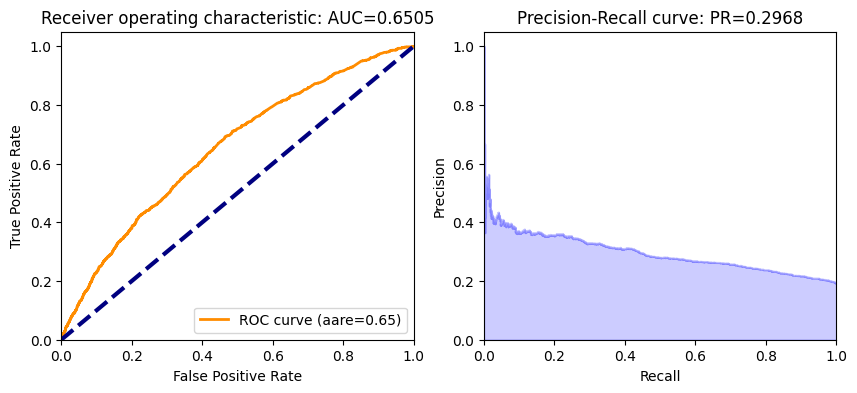

In [359]:
ROC_AUC(glm_v0,test_hex,'loan_default')

### Model 1: using all the raw features

In [360]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [361]:
glm_v1 = H2OGeneralizedLinearEstimator(family= "AUTO", lambda_ = 0.05)
glm_v1.train(predictors,target,training_frame=train_hex)

glm Model Build progress: |

c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\h2o\estimators\estimator_base.py:206: RuntimeWarning: Dropping bad and constant columns: [TD029, TD028, TD027, TD026, TD025, CR012]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1638595506565_128


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 0.05 )",73,7,2,Key_Frame__upload_b704d4b444695fd3f95de2393dd34e95.hex




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.15147421364709046
RMSE: 0.3891968828846018
MAE: 0.3065342467283834
RMSLE: 0.2724979062326415
R^2: 0.03237589815969921
Mean Residual Deviance: 0.15147421364709046
Null degrees of freedom: 47999
Residual degrees of freedom: 47992
Null deviance: 7514.035916666522
Residual deviance: 7270.762255060342
AIC: 45643.785165114605

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,training_rmse,training_deviance,training_mae,training_r2
0,,2021-12-04 18:04:00,0.000 sec,0,7514.035917,0.156542,,,,
1,,2021-12-04 18:04:00,0.017 sec,2,,,0.389197,0.151474,0.306534,0.032376



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013,0.021340,1.000000,0.301981
1,AP004,0.017039,0.798466,0.241122
2,AP003,0.013785,0.645966,0.195070
3,TD009,0.009457,0.443164,0.133827
4,TD005,0.006160,0.288660,0.087170
5,MB005,0.001741,0.081605,0.024643
6,PA028,0.001144,0.053602,0.016187
7,AP001,0.000000,0.000000,0.000000
8,AP002,0.000000,0.000000,0.000000
9,AP007,0.000000,0.000000,0.000000



See the whole table with table.as_data_frame()


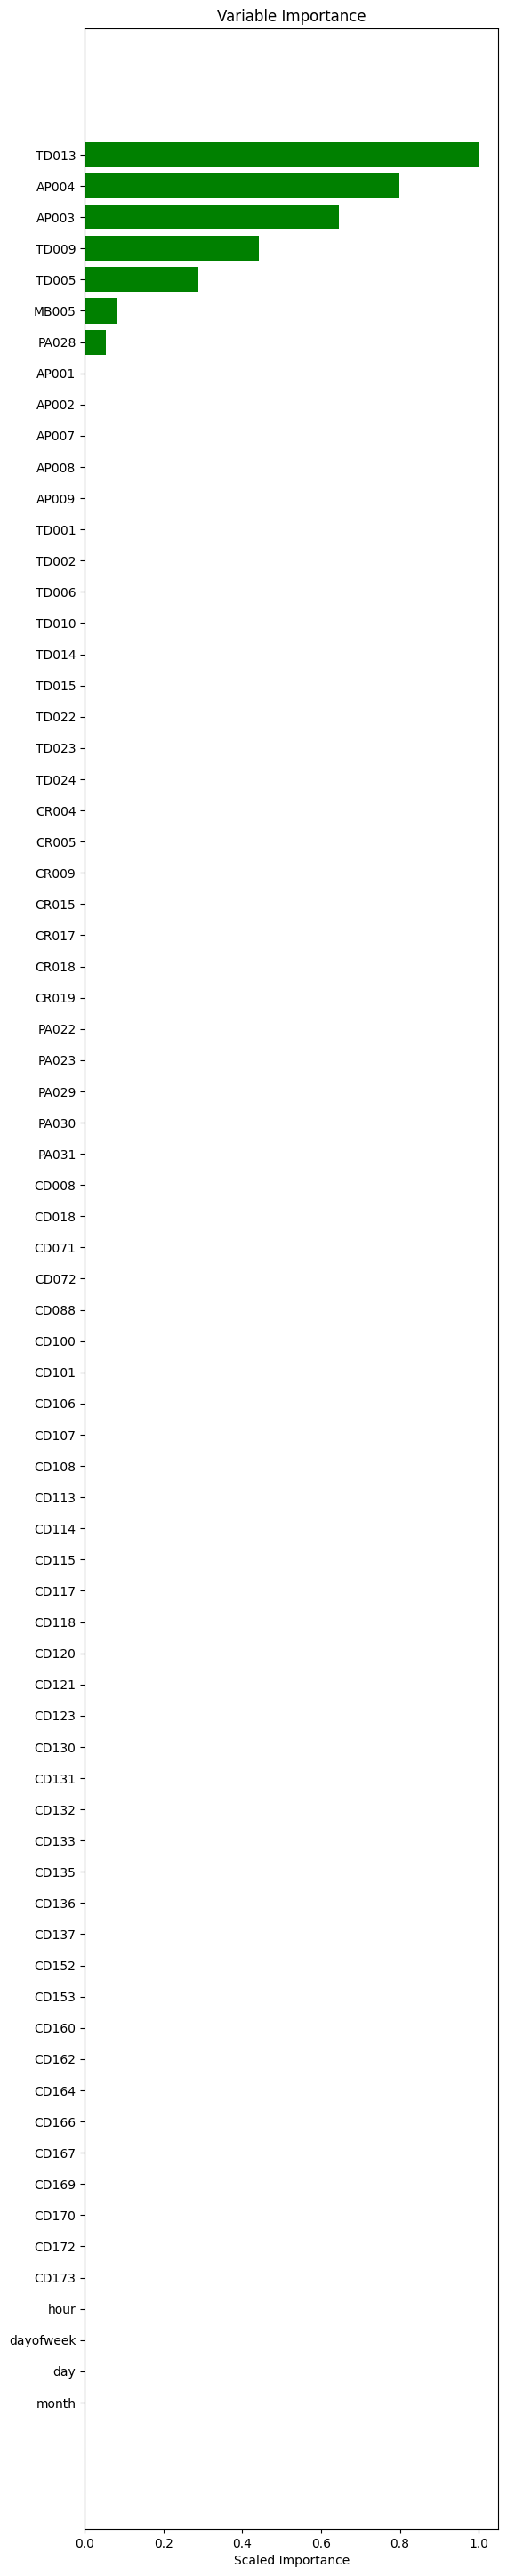

In [362]:
VarImp(glm_v1)

In [363]:
createGains(glm_v1)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1160,2040,3200,1160,2040,0.19,0.08,616.2,1.88,11.0,36.25
1,3200,905,2295,6400,2065,4335,0.34,0.17,1232.4,1.68,17.0,32.27
2,3200,809,2391,9600,2874,6726,0.47,0.26,1848.6,1.55,21.0,29.94
3,3200,706,2494,12800,3580,9220,0.58,0.36,2464.8,1.45,22.0,27.97
4,3200,613,2587,16000,4193,11807,0.68,0.46,3081.0,1.36,22.0,26.21
5,3200,526,2674,19200,4719,14481,0.77,0.56,3697.2,1.28,21.0,24.58
6,3200,475,2725,22400,5194,17206,0.84,0.67,4313.4,1.20,17.0,23.19
7,3200,416,2784,25600,5610,19990,0.91,0.77,4929.6,1.14,14.0,21.91
8,3200,364,2836,28800,5974,22826,0.97,0.88,5545.8,1.08,9.0,20.74


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



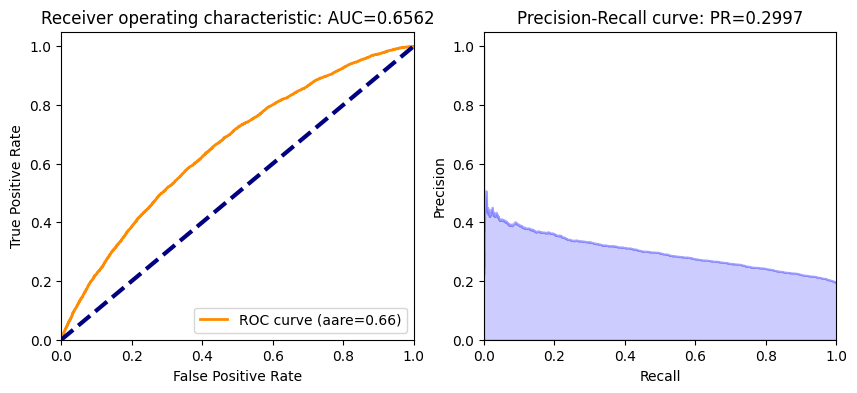

In [364]:
ROC_AUC(glm_v1,test_hex,'loan_default')

### Model 2: using all the engineered features

In [365]:
target = 'loan_default'
predictors = features2

In [366]:
glm_v2 = H2OGeneralizedLinearEstimator(family= "AUTO", lambda_ = 0.05)
glm_v2.train(predictors,target,training_frame=train_hex)

glm Model Build progress: |

c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\h2o\estimators\estimator_base.py:206: RuntimeWarning: Dropping bad and constant columns: [AP009_D_WOE, TD027_D_WOE, TD026_D_WOE, AP002_D_WOE, TD028_D_WOE, TD025_D_WOE, CR012_D_WOE, TD029_D_WOE]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1638595506565_129


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 0.05 )",71,9,2,Key_Frame__upload_b704d4b444695fd3f95de2393dd34e95.hex




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.15183505084077734
RMSE: 0.3896601735368619
MAE: 0.3070049243491859
RMSLE: 0.27285729620222715
R^2: 0.030070853907973927
Mean Residual Deviance: 0.15183505084077734
Null degrees of freedom: 47999
Residual degrees of freedom: 47990
Null deviance: 7514.035916666522
Residual deviance: 7288.0824403573115
AIC: 45761.99330509581

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,training_rmse,training_deviance,training_mae,training_r2
0,,2021-12-04 18:04:02,0.000 sec,0,7514.035917,0.156542,,,,
1,,2021-12-04 18:04:02,0.031 sec,2,,,0.38966,0.151835,0.307005,0.030071



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013_D_WOE,0.024623,1.000000,0.374598
1,AP004_D_WOE,0.016079,0.652991,0.244609
2,PA028_D_WOE,0.005617,0.228130,0.085457
3,TD009_D_WOE,0.004810,0.195351,0.073178
4,AP003_D_WOE,0.004577,0.185878,0.069630
5,TD005_D_WOE,0.004334,0.176015,0.065935
6,CR015_D_WOE,0.002488,0.101059,0.037856
7,MB005_D_WOE,0.001617,0.065656,0.024595
8,CD123_D_WOE,0.001587,0.064447,0.024142
9,AP001_D_WOE,0.000000,0.000000,0.000000



See the whole table with table.as_data_frame()


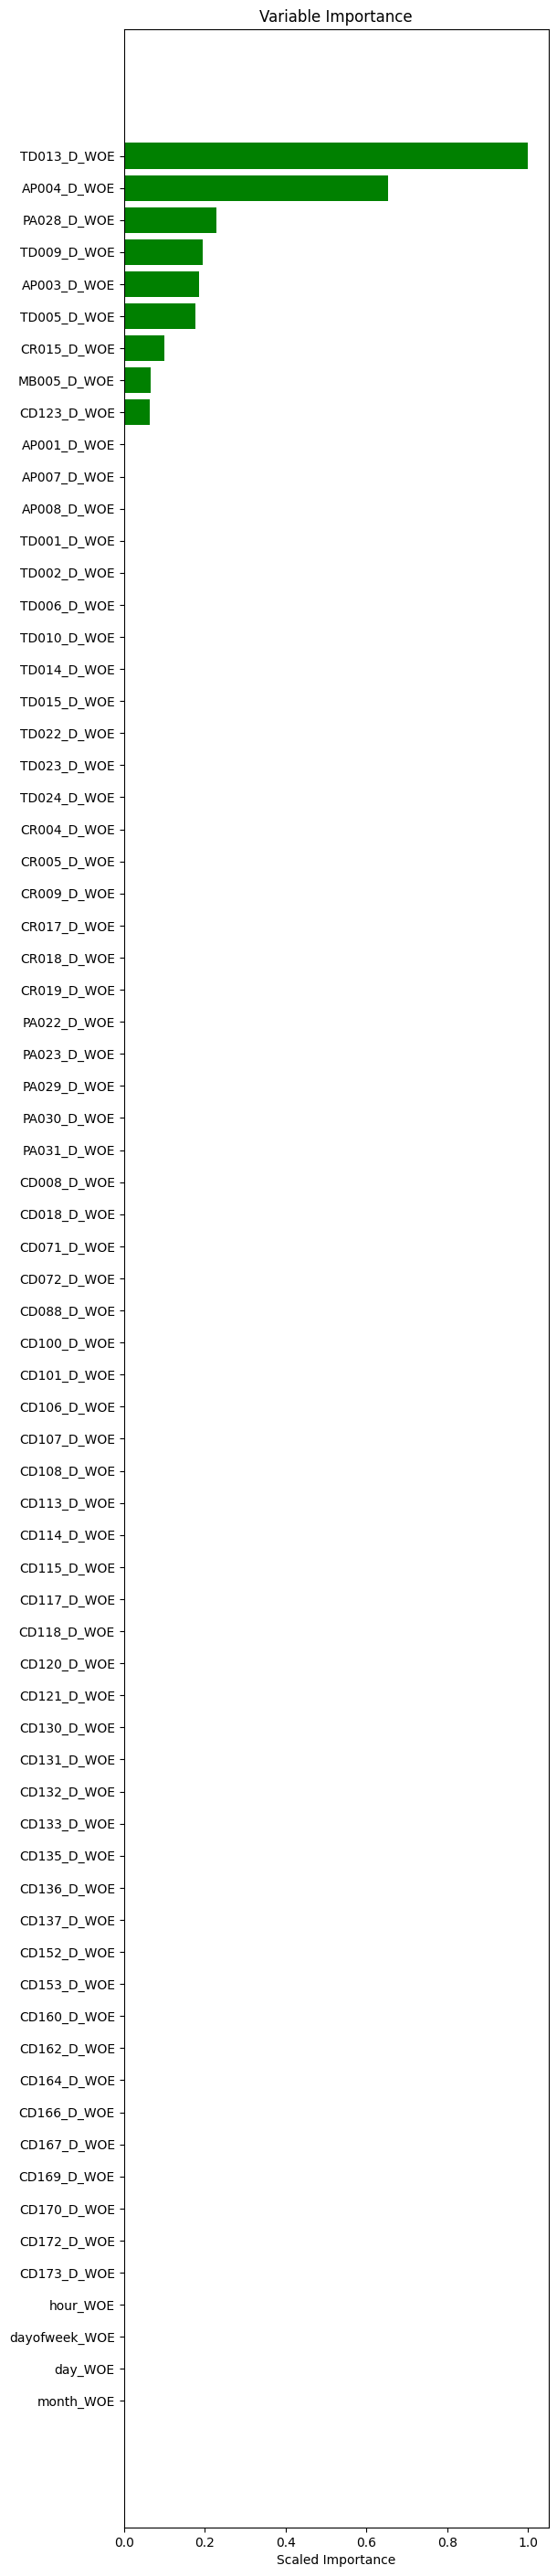

In [367]:
VarImp(glm_v2)

In [368]:
createGains(glm_v2)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1129,2071,3200,1129,2071,0.18,0.08,616.2,1.83,10.0,35.28
1,3200,900,2300,6400,2029,4371,0.33,0.17,1232.4,1.65,16.0,31.70
2,3200,820,2380,9600,2849,6751,0.46,0.26,1848.6,1.54,20.0,29.68
3,3200,696,2504,12800,3545,9255,0.58,0.36,2464.8,1.44,22.0,27.70
4,3200,582,2618,16000,4127,11873,0.67,0.46,3081.0,1.34,21.0,25.79
5,3200,525,2675,19200,4652,14548,0.75,0.56,3697.2,1.26,19.0,24.23
6,3200,502,2698,22400,5154,17246,0.84,0.67,4313.4,1.19,17.0,23.01
7,3200,424,2776,25600,5578,20022,0.91,0.77,4929.6,1.13,14.0,21.79
8,3200,316,2884,28800,5894,22906,0.96,0.89,5545.8,1.06,7.0,20.47


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



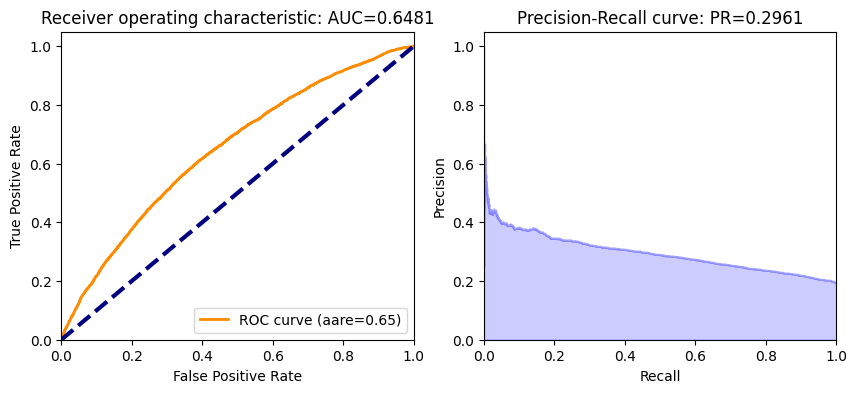

In [369]:
ROC_AUC(glm_v2,test_hex,'loan_default')

### Model 3: using mixture of raw and engineered features

In [370]:
target = 'loan_default'
predictors = features[1:]+features2

In [371]:
glm_v3 = H2OGeneralizedLinearEstimator(family= "AUTO", lambda_ = 0.05)
glm_v3.train(predictors,target,training_frame=train_hex)

glm Model Build progress: |

c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\h2o\estimators\estimator_base.py:206: RuntimeWarning: Dropping bad and constant columns: [AP009_D_WOE, TD027_D_WOE, TD026_D_WOE, AP002_D_WOE, CR012, TD029, TD028, TD028_D_WOE, TD027, TD026, TD025_D_WOE, CR012_D_WOE, TD025, TD029_D_WOE]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1638595506565_130


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 0.05 )",144,12,2,Key_Frame__upload_b704d4b444695fd3f95de2393dd34e95.hex




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.15093544591430014
RMSE: 0.3885041131240442
MAE: 0.3058874371638605
RMSLE: 0.27194843620614817
R^2: 0.035817570712338265
Mean Residual Deviance: 0.15093544591430014
Null degrees of freedom: 47999
Residual degrees of freedom: 47987
Null deviance: 7514.035916666522
Residual deviance: 7244.901403886407
AIC: 45482.7530719428

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,training_rmse,training_deviance,training_mae,training_r2
0,,2021-12-04 18:04:04,0.000 sec,0,7514.035917,0.156542,,,,
1,,2021-12-04 18:04:04,0.041 sec,2,,,0.388504,0.150935,0.305887,0.035818



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013_D_WOE,0.019118,1.000000,0.240654
1,AP003,0.013951,0.729707,0.175607
2,AP004,0.012875,0.673421,0.162061
3,TD009,0.007137,0.373302,0.089837
4,TD013,0.005591,0.292419,0.070372
5,PA028_D_WOE,0.004894,0.255989,0.061605
6,AP004_D_WOE,0.004217,0.220571,0.053081
7,TD005,0.004083,0.213544,0.051390
8,MB005_D_WOE,0.002660,0.139115,0.033478
9,CR015_D_WOE,0.002393,0.125170,0.030123



See the whole table with table.as_data_frame()


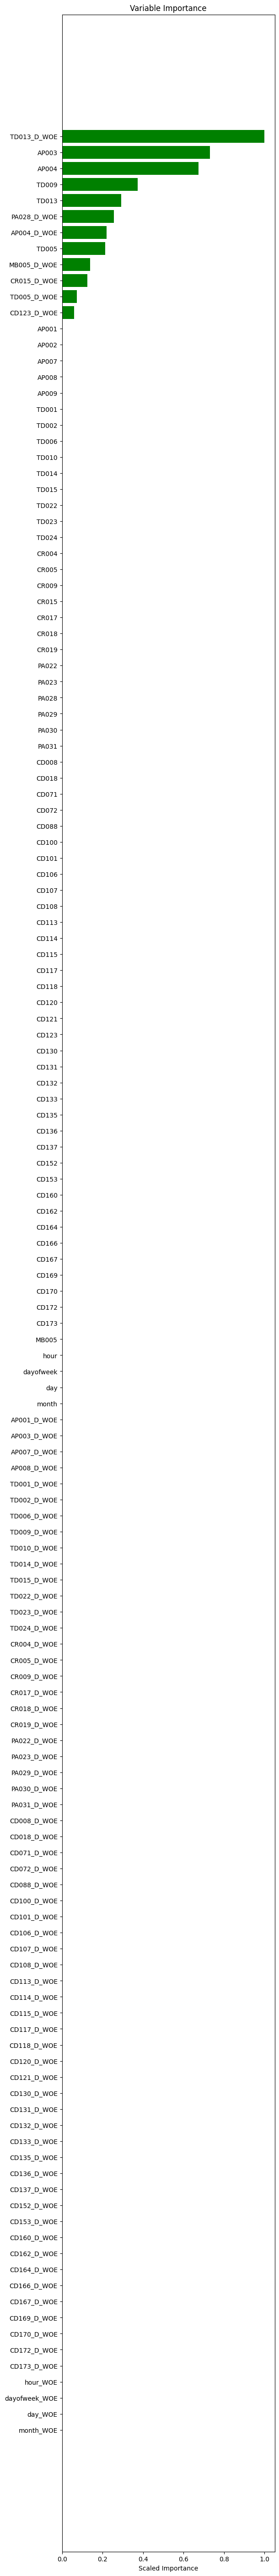

In [372]:
VarImp(glm_v3)

In [373]:
createGains(glm_v3)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1209,1991,3200,1209,1991,0.20,0.08,616.2,1.96,12.0,37.78
1,3200,935,2265,6400,2144,4256,0.35,0.16,1232.4,1.74,19.0,33.50
2,3200,800,2400,9600,2944,6656,0.48,0.26,1848.6,1.59,22.0,30.67
3,3200,684,2516,12800,3628,9172,0.59,0.35,2464.8,1.47,24.0,28.34
4,3200,602,2598,16000,4230,11770,0.69,0.46,3081.0,1.37,23.0,26.44
5,3200,541,2659,19200,4771,14429,0.77,0.56,3697.2,1.29,21.0,24.85
6,3200,458,2742,22400,5229,17171,0.85,0.66,4313.4,1.21,19.0,23.34
7,3200,390,2810,25600,5619,19981,0.91,0.77,4929.6,1.14,14.0,21.95
8,3200,343,2857,28800,5962,22838,0.97,0.88,5545.8,1.08,9.0,20.70


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



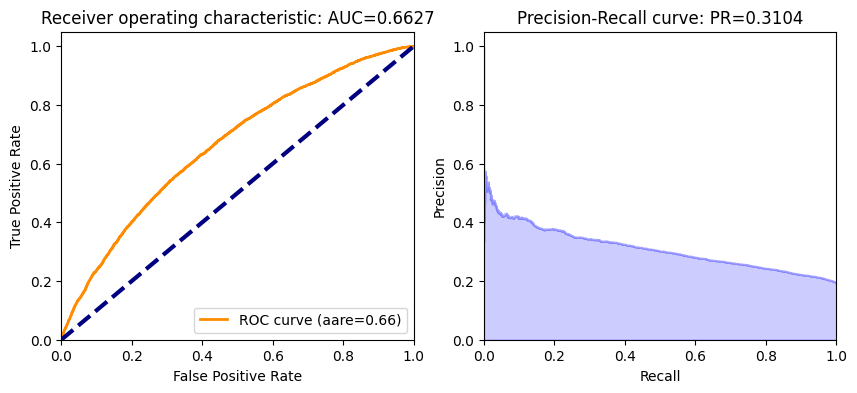

In [374]:
ROC_AUC(glm_v3,test_hex,'loan_default')

### Analysing variables from various models

In [375]:
def delete_dict(dic,limit):
    l=[]
    for i,j in dic.items():
        if j>=limit:
            l.append(i)
    return l

In [376]:
def get_importance(gbm):
    scaled_importance = list(gbm._model_json['output']['variable_importances']['scaled_importance'])
    variables = list(gbm._model_json['output']['variable_importances']['variable'])
    res = dict(zip(variables,scaled_importance))
    return res

In [377]:
var1 = set(delete_dict(get_importance(glm_v1),0.10))
var2 = set(delete_dict(get_importance(glm_v2),0.10))
var3 = set(delete_dict(get_importance(glm_v3),0.10))

In [378]:
var1.union(var2,var3)

{'AP003',
 'AP003_D_WOE',
 'AP004',
 'AP004_D_WOE',
 'CR015_D_WOE',
 'MB005_D_WOE',
 'PA028_D_WOE',
 'TD005',
 'TD005_D_WOE',
 'TD009',
 'TD009_D_WOE',
 'TD013',
 'TD013_D_WOE'}

### Model 4: using mixture of select features

In [404]:
target = 'loan_default'
predictors = ['AP003',
 'AP003_D_WOE',
 'AP004',
 'AP004_D_WOE',
 'CR015_D_WOE',
 'MB005_D_WOE',
 'PA028_D_WOE',
 'TD005',
 'TD005_D_WOE',
 'TD009',
 'TD009_D_WOE',
 'TD013',
 'TD013_D_WOE']

In [385]:
glm_v4 = H2OGeneralizedLinearEstimator(family= "AUTO", lambda_ = 0.05)
glm_v4.train(predictors,target,training_frame=train_hex)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1638595506565_132


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 0.05 )",13,12,2,Key_Frame__upload_b704d4b444695fd3f95de2393dd34e95.hex




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.15099233494370295
RMSE: 0.38857732170534987
MAE: 0.30594861708126936
RMSLE: 0.2720080115705252
R^2: 0.03545416102923071
Mean Residual Deviance: 0.15099233494370295
Null degrees of freedom: 47999
Residual degrees of freedom: 47987
Null deviance: 7514.035916666522
Residual deviance: 7247.6320772977415
AIC: 45500.8413275905

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,training_rmse,training_deviance,training_mae,training_r2
0,,2021-12-04 18:05:00,0.000 sec,0,7514.035917,0.156542,,,,
1,,2021-12-04 18:05:00,0.017 sec,2,,,0.388577,0.150992,0.305949,0.035454



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013_D_WOE,0.018313,1.000000,0.233698
1,AP003,0.013951,0.761791,0.178029
2,AP004,0.011669,0.637217,0.148916
3,TD009,0.006520,0.356047,0.083207
4,TD013,0.006478,0.353765,0.082674
5,AP004_D_WOE,0.005437,0.296913,0.069388
6,PA028_D_WOE,0.004688,0.255972,0.059820
7,TD005,0.004011,0.219044,0.051190
8,MB005_D_WOE,0.002793,0.152504,0.035640
9,CR015_D_WOE,0.002481,0.135482,0.031662


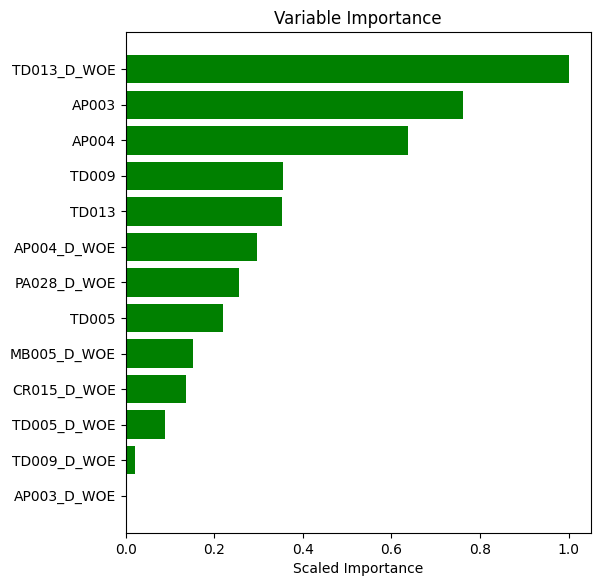

In [386]:
VarImp(glm_v4)

In [387]:
createGains(glm_v4)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1206,1994,3200,1206,1994,0.20,0.08,616.2,1.96,12.0,37.69
1,3200,926,2274,6400,2132,4268,0.35,0.17,1232.4,1.73,18.0,33.31
2,3200,804,2396,9600,2936,6664,0.48,0.26,1848.6,1.59,22.0,30.58
3,3200,685,2515,12800,3621,9179,0.59,0.36,2464.8,1.47,23.0,28.29
4,3200,606,2594,16000,4227,11773,0.69,0.46,3081.0,1.37,23.0,26.42
5,3200,541,2659,19200,4768,14432,0.77,0.56,3697.2,1.29,21.0,24.83
6,3200,447,2753,22400,5215,17185,0.85,0.67,4313.4,1.21,18.0,23.28
7,3200,397,2803,25600,5612,19988,0.91,0.77,4929.6,1.14,14.0,21.92
8,3200,347,2853,28800,5959,22841,0.97,0.88,5545.8,1.07,9.0,20.69


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



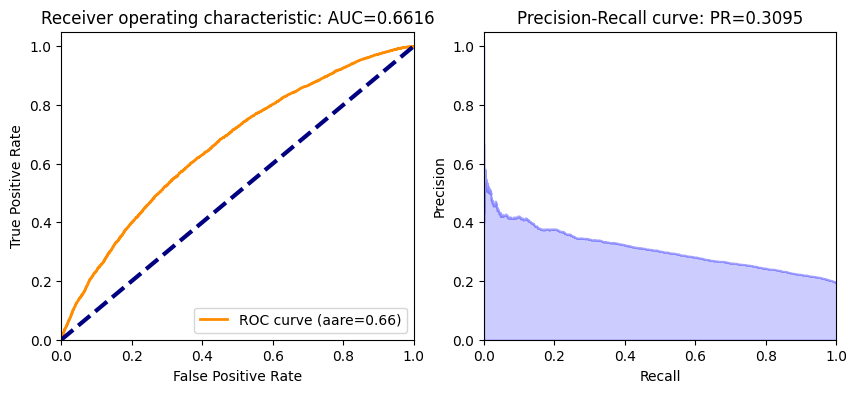

In [388]:
ROC_AUC(glm_v4,test_hex,'loan_default')

### Grid Search

In [390]:
from h2o.grid.grid_search import H2OGridSearch

In [405]:
hyper_params = {'alpha': [0.02,0.03,0.05,0.2,0.3,0.5],
                'lambda': [5e-2, 5e-3, 5e-4,5e-5, 5e-6, 5e-7]}

In [406]:
gs = H2OGridSearch(H2OGeneralizedLinearEstimator(family='AUTO'),
                   hyper_params)

In [407]:
gs.train(predictors,target, training_frame=train_hex)

glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\h2o\grid\grid_search.py:423: UserWarning: Adding alpha array to hyperparameter runs slower with gridsearch.  This is due to the fact that the algo has to run initialization for every alpha value.  Setting the alpha array as a model parameter will skip the initialization and run faster overall.
  warnings.warn(w_message);


      alpha        lambda  \
0      0.02  5.000000e-07   
1      0.03  5.000000e-07   
2      0.05  5.000000e-07   
3      0.20  5.000000e-07   
4      0.02  5.000000e-06   
5      0.30  5.000000e-07   
6      0.03  5.000000e-06   
7      0.50  5.000000e-07   
8      0.05  5.000000e-06   
9      0.50  5.000000e-06   
10     0.20  5.000000e-06   
11     0.05  5.000000e-05   
12     0.02  5.000000e-05   
13     0.30  5.000000e-06   
14     0.03  5.000000e-05   
15     0.20  5.000000e-05   
16     0.30  5.000000e-05   
17     0.02  5.000000e-04   
18     0.03  5.000000e-04   
19     0.50  5.000000e-05   
20     0.05  5.000000e-04   
21     0.20  5.000000e-04   
22     0.30  5.000000e-04   
23     0.50  5.000000e-04   
24     0.02  5.000000e-03   
25     0.03  5.000000e-03   
26     0.05  5.000000e-03   
27     0.20  5.000000e-03   
28     0.30  5.000000e-03   
29     0.02  5.000000e-02   
30     0.50  5.000000e-03   
31     0.03  5.000000e-02   
32     0.05  5.000000e-02   
33     0.20  5

In [425]:
best_model_id = gs.get_grid(sort_by='r2',
                            decreasing=True).model_ids[0]

In [426]:
gs.get_hyperparams_dict(best_model_id)

Hyperparameters: [alpha, lambda]


{'alpha': [0.02], 'lambda': [5e-07]}

### Apply the best model to best set of attributes

In [427]:
target = 'loan_default'
predictors = features[1:]+features2

In [428]:
glm_v5 = H2OGeneralizedLinearEstimator(family= "AUTO",alpha = 0.02 ,lambda_ = 5e-7)
glm_v5.train(predictors,target,training_frame=train_hex)

glm Model Build progress: |

c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\h2o\estimators\estimator_base.py:206: RuntimeWarning: Dropping bad and constant columns: [AP009_D_WOE, TD027_D_WOE, TD026_D_WOE, AP002_D_WOE, CR012, TD029, TD028, TD028_D_WOE, TD027, TD026, TD025_D_WOE, CR012_D_WOE, TD025, TD029_D_WOE]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1638595506565_139


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.02, lambda = 5.0E-7 )",144,143,1,Key_Frame__upload_b704d4b444695fd3f95de2393dd34e95.hex




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.14342883066817155
RMSE: 0.37871998979215704
MAE: 0.2924007388325028
RMSLE: 0.266588084995744
R^2: 0.08377016713458352
Mean Residual Deviance: 0.14342883066817155
Null degrees of freedom: 47999
Residual degrees of freedom: 47856
Null deviance: 7514.035916666522
Residual deviance: 6884.583872072234
AIC: 43296.11581132867

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,training_rmse,training_deviance,training_mae,training_r2
0,,2021-12-04 18:09:54,0.000 sec,0,7514.035917,0.156542,,,,
1,,2021-12-04 18:09:54,0.262 sec,1,,,0.37872,0.143429,0.292401,0.08377



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,CD106,0.059383,1.000000,0.036878
1,CD121,0.055240,0.930221,0.034305
2,CD108,0.044826,0.754861,0.027838
3,CD123,0.044159,0.743626,0.027424
4,CD107,0.043345,0.729923,0.026918
5,AP003,0.043064,0.725189,0.026744
6,CD118,0.038765,0.652796,0.024074
7,CD117,0.034357,0.578565,0.021336
8,CD172,0.031778,0.535125,0.019734
9,AP004,0.031405,0.528844,0.019503



See the whole table with table.as_data_frame()


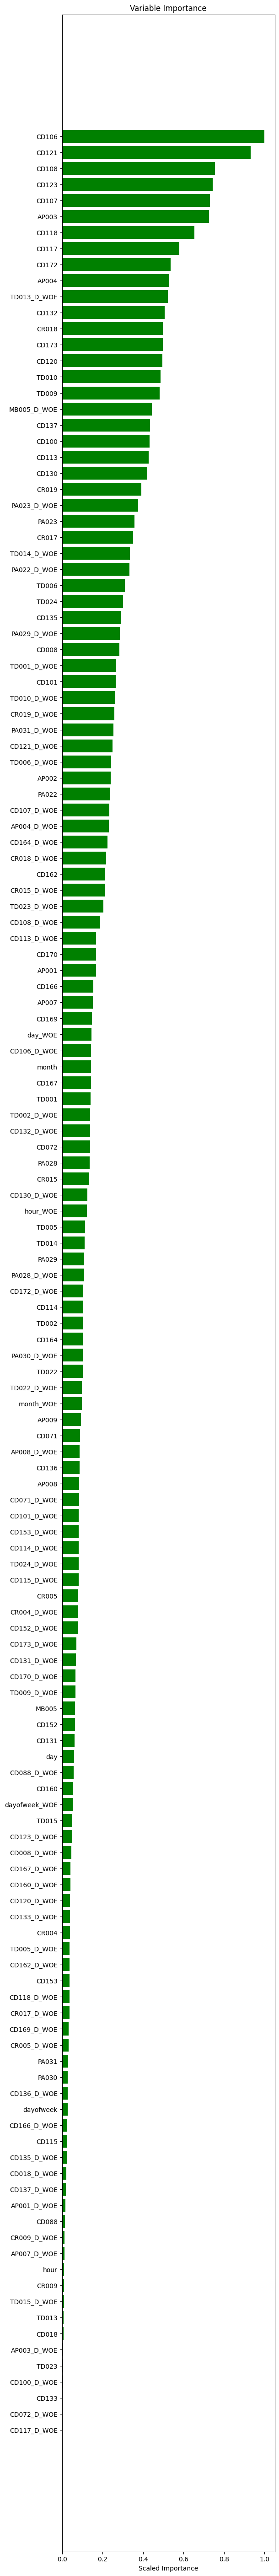

In [429]:
VarImp(glm_v5)

In [430]:
createGains(glm_v5)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1347,1853,3200,1347,1853,0.22,0.07,616.2,2.19,15.0,42.09
1,3200,1035,2165,6400,2382,4018,0.39,0.16,1232.4,1.93,23.0,37.22
2,3200,804,2396,9600,3186,6414,0.52,0.25,1848.6,1.72,27.0,33.19
3,3200,696,2504,12800,3882,8918,0.63,0.35,2464.8,1.57,28.0,30.33
4,3200,642,2558,16000,4524,11476,0.73,0.44,3081.0,1.47,29.0,28.28
5,3200,519,2681,19200,5043,14157,0.82,0.55,3697.2,1.36,27.0,26.27
6,3200,417,2783,22400,5460,16940,0.89,0.66,4313.4,1.27,23.0,24.38
7,3200,321,2879,25600,5781,19819,0.94,0.77,4929.6,1.17,17.0,22.58
8,3200,241,2959,28800,6022,22778,0.98,0.88,5545.8,1.09,10.0,20.91


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



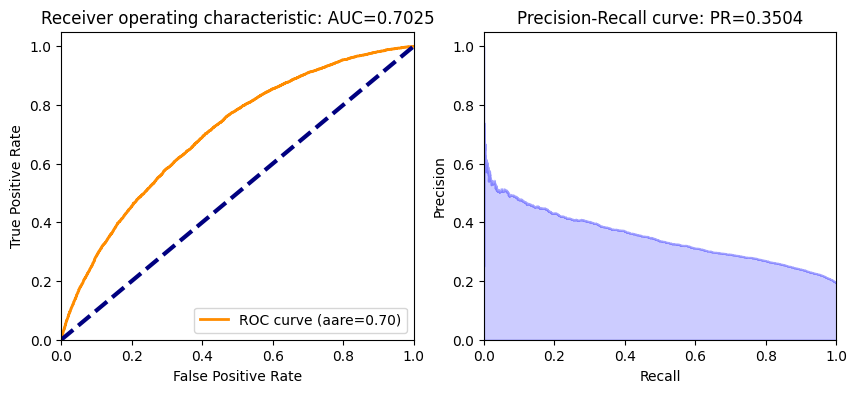

In [431]:
ROC_AUC(glm_v5,test_hex,'loan_default')

## AutoML

The Automatic Machine Learning (AutoML) function automates the supervised machine learning model training process. The current version of AutoML trains and cross-validates the following algorithms (in the following order): three pre-specified XGBoost GBM (Gradient Boosting Machine) models, a fixed grid of GLMs, a default Random Forest (DRF), five pre-specified H2O GBMs, a near-default Deep Neural Net, an Extremely Randomized Forest (XRT), a random grid of XGBoost GBMs, a random grid of H2O GBMs, and a random grid of Deep Neural Nets. In some cases, there will not be enough time to complete all the algorithms, so some may be missing from the leaderboard. AutoML trains several Stacked Ensemble models during the run. Two kinds of Stacked Ensemble models are trained one of all available models, and one of only the best models of each kind. Note that Stacked Ensemble models are trained only if there isn’t another stacked ensemble with the same base models.

### Model 0: using 10% of the data data set

In [432]:
from h2o.automl import H2OAutoML

In [433]:
target = 'loan_default'
predictors = ['AP001','AP002','AP003','AP004','AP007','AP008','AP009','TD001','TD002','TD005','TD006','TD009','TD010','TD013','TD014','TD015','TD022','TD023','TD024','TD025','TD026','TD027','TD028','TD029','CR004','CR005','CR009','CR012','CR015','CR017','CR018','CR019','PA022','PA023','PA028','PA029','PA030','PA031','CD008','CD018','CD071','CD072','CD088','CD100','CD101','CD106','CD107','CD108','CD113','CD114','CD115','CD117','CD118','CD120','CD121','CD123','CD130','CD131','CD132','CD133','CD135','CD136','CD137','CD152','CD153','CD160','CD162','CD164','CD166','CD167','CD169','CD170','CD172','CD173','MB005','hour','dayofweek','day','month']

In [434]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [468]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_v0 = H2OAutoML(max_runtime_secs = 120, 
                   max_models=20, 
                   nfolds = 25,
                   seed=414,
                   balance_classes=True,
                   keep_cross_validation_predictions=True, 
                   keep_cross_validation_models=True)
aml_v0.train(predictors,target,training_frame=train_hex)

AutoML progress: |
19:48:21.640: AutoML: XGBoost is not available; skipping it.
19:48:21.640: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
19:48:21.640: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

█████████████████████████████████████████████████████
19:50:03.455: DeepLearning_1_AutoML_6_20211204_194821 [DeepLearning def_1] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for DeepLearning model: DeepLearning_1_AutoML_6_20211204_194821_cv_1.  Details: ERRR on field: _balance_classes: balance_classes requires classification.


██████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_2_AutoML_6_20211204_194821

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.12187024392653745
RMSE: 0.349099189237869
MAE: 0.26600561122816013
RMSLE: 0.24271478028276017

In [469]:
aml_v0.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_2_AutoML_6_20211204_194821,0.145013,0.380806,0.145013,0.291205,0.267358
StackedEnsemble_AllModels_1_AutoML_6_20211204_194821,0.145014,0.380807,0.145014,0.291226,0.267357
StackedEnsemble_BestOfFamily_1_AutoML_6_20211204_194821,0.145025,0.380821,0.145025,0.291645,0.267438
StackedEnsemble_AllModels_3_AutoML_6_20211204_194821,0.145055,0.380861,0.145055,0.291226,0.267392
StackedEnsemble_BestOfFamily_3_AutoML_6_20211204_194821,0.145104,0.380926,0.145104,0.291706,0.267518
StackedEnsemble_BestOfFamily_2_AutoML_6_20211204_194821,0.145116,0.380941,0.145116,0.291717,0.267527
GBM_1_AutoML_6_20211204_194821,0.145932,0.38201,0.145932,0.292543,0.268144
GLM_1_AutoML_6_20211204_194821,0.146662,0.382965,0.146662,0.297071,0.268962
GBM_2_AutoML_6_20211204_194821,0.148052,0.384775,0.148052,0.293581,0.270339
GBM_5_AutoML_6_20211204_194821,0.149711,0.386925,0.149711,0.297416,0.271978


In [470]:
pred = aml_v0.predict(test_hex)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
0.30146
0.138892
0.0692919
0.252595
0.175027
0.10979
0.115388
0.147861
0.098648
0.365376


In [471]:
perf = aml_v0.leader.model_performance(test_hex)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.14473482880745503
RMSE: 0.38044030912543303
MAE: 0.288295786472741
RMSLE: 0.2674894773058351
R^2: 0.06542081281779721
Mean Residual Deviance: 0.14473482880745503
Null degrees of freedom: 3199
Residual degrees of freedom: 3194
Null deviance: 495.6100000000081
Residual deviance: 463.1514521838561
AIC: 2910.080284054578


In [472]:
createGains(aml_v0)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,126,194,320,126,194,0.21,0.07,61.3,2.06,14.0,39.38
1,320,100,220,640,226,414,0.37,0.16,122.6,1.84,21.0,35.31
2,320,90,230,960,316,644,0.52,0.25,183.9,1.72,27.0,32.92
3,320,64,256,1280,380,900,0.62,0.35,245.2,1.55,27.0,29.69
4,320,56,264,1600,436,1164,0.71,0.45,306.5,1.42,26.0,27.25
5,320,50,270,1920,486,1434,0.79,0.55,367.8,1.32,24.0,25.31
6,320,38,282,2240,524,1716,0.85,0.66,429.1,1.22,19.0,23.39
7,320,46,274,2560,570,1990,0.93,0.77,490.4,1.16,16.0,22.27
8,320,27,293,2880,597,2283,0.97,0.88,551.7,1.08,9.0,20.73


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



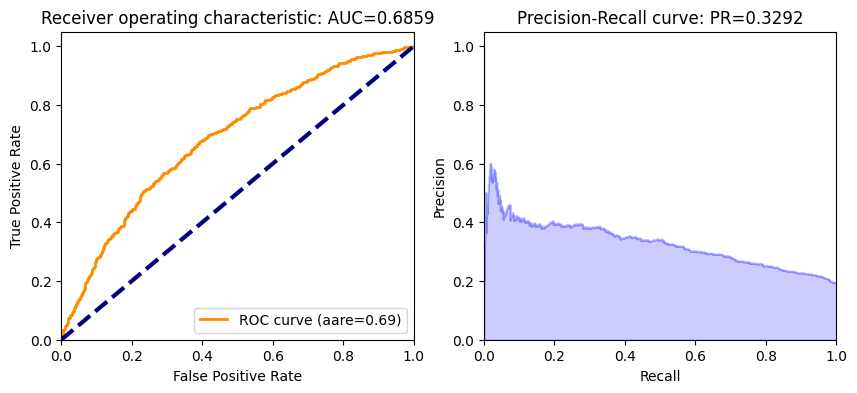

In [473]:
ROC_AUC(aml_v0,test_hex,'loan_default')

### Model 1: using the entire data set

In [474]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [508]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_v1 = H2OAutoML(max_runtime_secs = 120, 
                   max_models=20)
                   #,nfolds = 25,
                   #seed=414,
                   #balance_classes=True,
                   #keep_cross_validation_predictions=True, 
                   #keep_cross_validation_models=True)
aml_v1.train(predictors,target,training_frame=train_hex)

AutoML progress: |
20:16:50.44: AutoML: XGBoost is not available; skipping it.
20:16:50.45: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
20:16:50.45: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_2_AutoML_13_20211204_201650

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.13031241756739462
RMSE: 0.36098811277851606
MAE: 0.2760529927932995
RMSLE: 0.25210194652527335
R^2: 0.16585707412242
Mean Residual Deviance: 0.13031241756739462
Null degrees of freedom: 10047
Residual degrees of freedom: 10039
Null deviance: 1569.7327314444449
Residual deviance: 1309.3791717171812
AIC: 8058.968383646308

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 

In [509]:
aml_v1.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_2_AutoML_13_20211204_201650,0.145355,0.381255,0.145355,0.291603,0.267651
StackedEnsemble_BestOfFamily_3_AutoML_13_20211204_201650,0.145483,0.381423,0.145483,0.292109,0.267814
StackedEnsemble_AllModels_1_AutoML_13_20211204_201650,0.145533,0.381487,0.145533,0.292649,0.267905
StackedEnsemble_BestOfFamily_1_AutoML_13_20211204_201650,0.145644,0.381634,0.145644,0.293324,0.268085
StackedEnsemble_BestOfFamily_2_AutoML_13_20211204_201650,0.145719,0.381732,0.145719,0.293578,0.268161
GLM_1_AutoML_13_20211204_201650,0.146097,0.382226,0.146097,0.295574,0.26862
DeepLearning_1_AutoML_13_20211204_201650,0.146704,0.38302,0.146704,0.290781,0.268885
GBM_2_AutoML_13_20211204_201650,0.146962,0.383357,0.146962,0.294895,0.268841
GBM_1_AutoML_13_20211204_201650,0.147101,0.383538,0.147101,0.293051,0.269276
GBM_3_AutoML_13_20211204_201650,0.147467,0.384014,0.147467,0.295383,0.269371


In [510]:
pred = aml_v1.predict(test_hex)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
0.0395481
0.187104
0.413135
0.26577
0.308993
0.21963
0.204255
0.137676
0.335466
0.0669095


In [511]:
perf = aml_v1.leader.model_performance(test_hex)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.14451606411766296
RMSE: 0.38015268526956764
MAE: 0.2910924062555147
RMSLE: 0.26728110055489074
R^2: 0.07052974959973368
Mean Residual Deviance: 0.14451606411766296
Null degrees of freedom: 31999
Residual degrees of freedom: 31991
Null deviance: 4975.5255555554595
Residual deviance: 4624.514051765214
AIC: 28932.39869328569


In [512]:
createGains(aml_v1)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1279,1921,3200,1279,1921,0.21,0.07,616.2,2.08,14.0,39.97
1,3200,999,2201,6400,2278,4122,0.37,0.16,1232.4,1.85,21.0,35.59
2,3200,846,2354,9600,3124,6476,0.51,0.25,1848.6,1.69,26.0,32.54
3,3200,724,2476,12800,3848,8952,0.62,0.35,2464.8,1.56,27.0,30.06
4,3200,614,2586,16000,4462,11538,0.72,0.45,3081.0,1.45,27.0,27.89
5,3200,494,2706,19200,4956,14244,0.80,0.55,3697.2,1.34,25.0,25.81
6,3200,400,2800,22400,5356,17044,0.87,0.66,4313.4,1.24,21.0,23.91
7,3200,376,2824,25600,5732,19868,0.93,0.77,4929.6,1.16,16.0,22.39
8,3200,281,2919,28800,6013,22787,0.98,0.88,5545.8,1.08,10.0,20.88


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



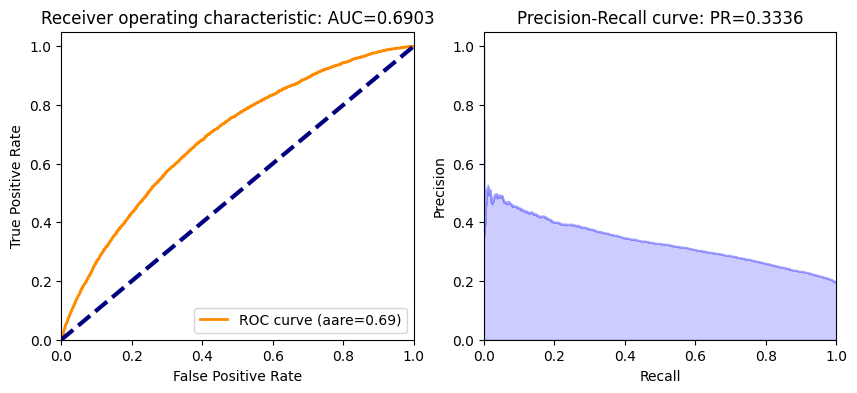

In [513]:
ROC_AUC(aml_v1,test_hex,'loan_default')

### Model 2: using all the engineered features

In [514]:
target = 'loan_default'
predictors = features2

In [515]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_v2 = H2OAutoML(max_runtime_secs = 120, max_models=20)
aml_v2.train(predictors,target,training_frame=train_hex)

AutoML progress: |
20:19:50.103: AutoML: XGBoost is not available; skipping it.
20:19:50.104: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
20:19:50.104: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_2_AutoML_14_20211204_201950

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.12989534556643192
RMSE: 0.3604099687389791
MAE: 0.272859144580907
RMSLE: 0.2514264909792613
R^2: 0.15288350529872896
Mean Residual Deviance: 0.12989534556643192
Null degrees of freedom: 10068
Residual degrees of freedom: 10061
Null deviance: 1544.2345490642356
Residual deviance: 1307.916234508403
AIC: 8041.4915063344715

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MS

In [516]:
aml_v2.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_2_AutoML_14_20211204_201950,0.145382,0.38129,0.145382,0.291945,0.267712
StackedEnsemble_BestOfFamily_3_AutoML_14_20211204_201950,0.145416,0.381335,0.145416,0.292184,0.267786
StackedEnsemble_AllModels_1_AutoML_14_20211204_201950,0.145523,0.381475,0.145523,0.292668,0.267902
StackedEnsemble_BestOfFamily_1_AutoML_14_20211204_201950,0.145594,0.381568,0.145594,0.293192,0.268032
StackedEnsemble_BestOfFamily_2_AutoML_14_20211204_201950,0.145603,0.38158,0.145603,0.293187,0.268039
GLM_1_AutoML_14_20211204_201950,0.146097,0.382226,0.146097,0.295574,0.26862
GBM_1_AutoML_14_20211204_201950,0.147016,0.383426,0.147016,0.292981,0.269182
GBM_2_AutoML_14_20211204_201950,0.147123,0.383566,0.147123,0.295269,0.269021
DeepLearning_1_AutoML_14_20211204_201950,0.147462,0.384008,0.147462,0.303495,0.272215
GBM_3_AutoML_14_20211204_201950,0.14778,0.384422,0.14778,0.296166,0.26962


In [517]:
pred = aml_v2.predict(test_hex)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
0.021002
0.168944
0.373305
0.220544
0.313517
0.209676
0.224109
0.126763
0.315235
0.0848655


In [518]:
perf = aml_v2.leader.model_performance(test_hex)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.1445907784232069
RMSE: 0.3802509413837221
MAE: 0.28729439752327446
RMSLE: 0.2662917656193199
R^2: 0.07004921669353814
Mean Residual Deviance: 0.1445907784232069
Null degrees of freedom: 31999
Residual degrees of freedom: 31992
Null deviance: 4975.5255555554595
Residual deviance: 4626.904909542621
AIC: 28946.93830756544


In [519]:
createGains(aml_v2)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1301,1899,3200,1301,1899,0.21,0.07,616.2,2.11,14.0,40.66
1,3200,960,2240,6400,2261,4139,0.37,0.16,1232.4,1.83,21.0,35.33
2,3200,866,2334,9600,3127,6473,0.51,0.25,1848.6,1.69,26.0,32.57
3,3200,722,2478,12800,3849,8951,0.62,0.35,2464.8,1.56,27.0,30.07
4,3200,600,2600,16000,4449,11551,0.72,0.45,3081.0,1.44,27.0,27.81
5,3200,508,2692,19200,4957,14243,0.80,0.55,3697.2,1.34,25.0,25.82
6,3200,421,2779,22400,5378,17022,0.87,0.66,4313.4,1.25,21.0,24.01
7,3200,352,2848,25600,5730,19870,0.93,0.77,4929.6,1.16,16.0,22.38
8,3200,280,2920,28800,6010,22790,0.98,0.88,5545.8,1.08,10.0,20.87


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



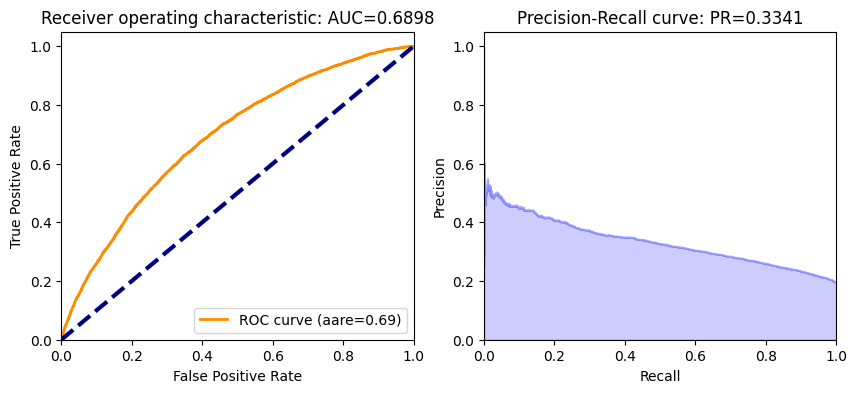

In [520]:
ROC_AUC(aml_v2,test_hex,'loan_default')

### Model 3: using mixture of raw and engineered features

In [521]:
target = 'loan_default'
predictors = features[1:]+features2

In [535]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_v3 = H2OAutoML(max_runtime_secs = 120, max_models=20,
                   nfolds = 48,
                   seed=414,
                   balance_classes=True,
                   keep_cross_validation_predictions=True, 
                   keep_cross_validation_models=True)
aml_v3.train(predictors,target,training_frame=train_hex)

AutoML progress: |
20:29:50.154: AutoML: XGBoost is not available; skipping it.
20:29:50.156: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
20:29:50.156: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_1_AutoML_17_20211204_202950

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.14149085809512266
RMSE: 0.37615270581922267
MAE: 0.29000873778694153
RMSLE: 0.2643648602488842
R^2: 0.08912402134274511
Mean Residual Deviance: 0.14149085809512266
Null degrees of freedom: 9977
Residual degrees of freedom: 9975
Null deviance: 1549.9706171562495
Residual deviance: 1411.795782073134
AIC: 8812.157101520574

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **


In [536]:
aml_v3.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_1_AutoML_17_20211204_202950,0.144253,0.379807,0.144253,0.292791,0.267108
GLM_1_AutoML_17_20211204_202950,0.144362,0.379951,0.144362,0.293547,0.267072
GBM_1_AutoML_17_20211204_202950,0.152144,0.390056,0.152144,0.308002,0.273154


In [537]:
pred = aml_v3.predict(test_hex)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
0.0311711
0.170018
0.377227
0.287084
0.337878
0.207751
0.27244
0.120783
0.324374
0.0818043


In [538]:
perf = aml_v3.leader.model_performance(test_hex)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.1434067416968121
RMSE: 0.3786908260003299
MAE: 0.2912231587794041
RMSLE: 0.2662141369476445
R^2: 0.07766447330382908
Mean Residual Deviance: 0.1434067416968121
Null degrees of freedom: 31999
Residual degrees of freedom: 31997
Null deviance: 4975.5255555554595
Residual deviance: 4589.015734297987
AIC: 28673.815286881978


In [539]:
createGains(aml_v3)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1366,1834,3200,1366,1834,0.22,0.07,616.2,2.22,15.0,42.69
1,3200,1026,2174,6400,2392,4008,0.39,0.16,1232.4,1.94,23.0,37.38
2,3200,817,2383,9600,3209,6391,0.52,0.25,1848.6,1.74,27.0,33.43
3,3200,692,2508,12800,3901,8899,0.63,0.34,2464.8,1.58,29.0,30.48
4,3200,635,2565,16000,4536,11464,0.74,0.44,3081.0,1.47,30.0,28.35
5,3200,523,2677,19200,5059,14141,0.82,0.55,3697.2,1.37,27.0,26.35
6,3200,383,2817,22400,5442,16958,0.88,0.66,4313.4,1.26,22.0,24.29
7,3200,340,2860,25600,5782,19818,0.94,0.77,4929.6,1.17,17.0,22.59
8,3200,244,2956,28800,6026,22774,0.98,0.88,5545.8,1.09,10.0,20.92


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



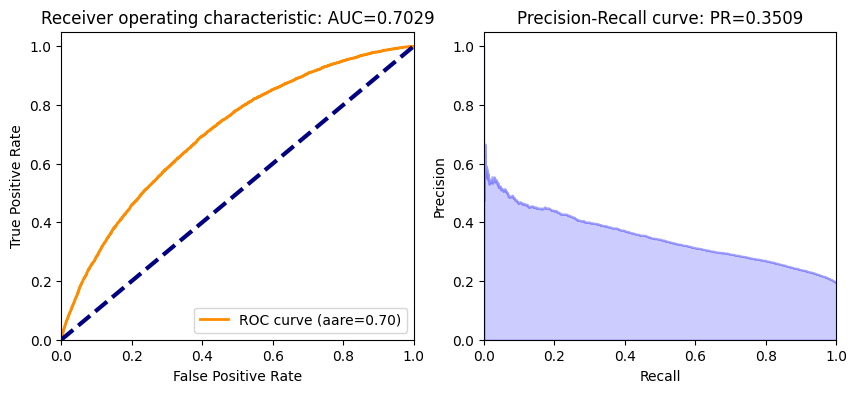

In [540]:
ROC_AUC(aml_v3,test_hex,'loan_default')

### Model 4: using mixture of select features

In [541]:
target = 'loan_default'
predictors = ['AP001_D_WOE',
 'AP002',
 'AP003','AP003_D_WOE',
 'AP004','AP004_D_WOE',
 'AP007_D_WOE',
 'CD108_D_WOE',
 'CD113','CD113_D_WOE',
 'CD114','CD114_D_WOE',
 'CD117','CD117_D_WOE',
 'CD120','CD120_D_WOE',
 'CD121_D_WOE',
 'CD123','CD123_D_WOE',
 'CR015','CR015_D_WOE',
 'MB005','MB005_D_WOE',
 'PA022','PA022_D_WOE',
 'PA023',
 'PA028','PA028_D_WOE',
 'PA029',
 'TD001',
 'TD005','TD005_D_WOE',
 'TD009','TD009_D_WOE',
 'TD013','TD013_D_WOE',
 'TD014','TD014_D_WOE',
 'day_WOE',
 'month']

In [542]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_v4 = H2OAutoML(max_runtime_secs = 120, max_models=20,
                   nfolds = 48,
                   seed=414,
                   balance_classes=True,
                   keep_cross_validation_predictions=True, 
                   keep_cross_validation_models=True)
aml_v4.train(predictors,target,training_frame=train_hex)

AutoML progress: |
20:33:44.791: AutoML: XGBoost is not available; skipping it.
20:33:44.791: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
20:33:44.791: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_18_20211204_203344

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.13455467021278011
RMSE: 0.366816943737309
MAE: 0.2801746769770531
RMSLE: 0.25737473740519873
R^2: 0.11862505119660549
Mean Residual Deviance: 0.13455467021278011
Null degrees of freedom: 9977
Residual degrees of freedom: 9973
Null deviance: 1523.6797004895825
Residual deviance: 1342.5864993831199
AIC: 8314.61770643547

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE:

In [543]:
aml_v4.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_1_AutoML_18_20211204_203344,0.144826,0.380561,0.144826,0.292128,0.267392
StackedEnsemble_BestOfFamily_2_AutoML_18_20211204_203344,0.144827,0.380562,0.144827,0.292136,0.267393
StackedEnsemble_BestOfFamily_1_AutoML_18_20211204_203344,0.144842,0.380581,0.144842,0.292178,0.267408
GLM_1_AutoML_18_20211204_203344,0.145226,0.381086,0.145226,0.294732,0.26773
GBM_1_AutoML_18_20211204_203344,0.146292,0.382481,0.146292,0.29525,0.267993
GBM_2_AutoML_18_20211204_203344,0.153476,0.39176,0.153476,0.309675,0.274435
GBM_3_AutoML_18_20211204_203344,0.153576,0.391887,0.153576,0.30986,0.274559
GBM_4_AutoML_18_20211204_203344,0.154869,0.393534,0.154869,0.311272,0.275872
DRF_1_AutoML_18_20211204_203344,0.275531,0.524911,0.275531,0.298227,0.365012


In [544]:
pred = aml_v4.predict(test_hex)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
0.0178145
0.208668
0.361173
0.280524
0.380092
0.17272
0.294838
0.0830889
0.326631
0.0774836


In [545]:
perf = aml_v4.leader.model_performance(test_hex)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.14398545455700903
RMSE: 0.379454153432281
MAE: 0.29038248766499114
RMSLE: 0.266620287623272
R^2: 0.07394242073921498
Mean Residual Deviance: 0.14398545455700903
Null degrees of freedom: 31999
Residual degrees of freedom: 31995
Null deviance: 4975.5255555554595
Residual deviance: 4607.534545824289
AIC: 28806.69030017865


In [546]:
createGains(aml_v4)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1316,1884,3200,1316,1884,0.21,0.07,616.2,2.14,14.0,41.12
1,3200,1016,2184,6400,2332,4068,0.38,0.16,1232.4,1.89,22.0,36.44
2,3200,853,2347,9600,3185,6415,0.52,0.25,1848.6,1.72,27.0,33.18
3,3200,682,2518,12800,3867,8933,0.63,0.35,2464.8,1.57,28.0,30.21
4,3200,602,2598,16000,4469,11531,0.73,0.45,3081.0,1.45,28.0,27.93
5,3200,523,2677,19200,4992,14208,0.81,0.55,3697.2,1.35,26.0,26.00
6,3200,407,2793,22400,5399,17001,0.88,0.66,4313.4,1.25,22.0,24.10
7,3200,350,2850,25600,5749,19851,0.93,0.77,4929.6,1.17,16.0,22.46
8,3200,258,2942,28800,6007,22793,0.97,0.88,5545.8,1.08,9.0,20.86


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



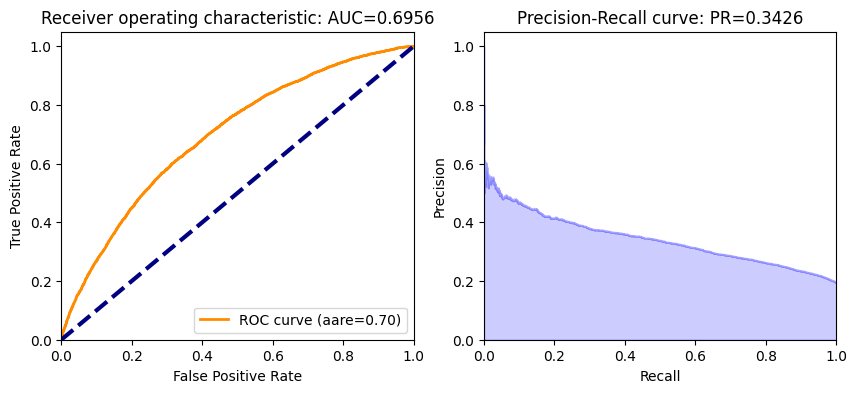

In [547]:
ROC_AUC(aml_v4,test_hex,'loan_default')

## Conclusion:

GLM: Five different models were tried using different subsets of features. The best set of features was the combination of both raw and engineered features, aftering removing erroneous attributes we have leveraged a total of 144 features to construct the model. 
Similarly, using grid search different values were tried for the parameters alpha and Lambda. The best values were alpha = 0.02 and Lambda = 5e-7.

The combination of these resulted in the best GLM model with AUC of 0.7025, Precision of 0.3504 and lift of 2.19. 

AutoML: We have tried various tuning of parameter and using different set of features as well. We have found the most optimal model for AutoML model 3 which has the AUC of 0.7029, Precision of 0.3509 and lift of 2.22.

###### Highlights
* GLM: best performing model was model 5 which has the AUC of 0.7025, Precision of 0.3504 and lift of 2.19. 

* AutoML: best performing model was model 3 which has the AUC of 0.7029, Precision of 0.3509 and lift of 2.22.

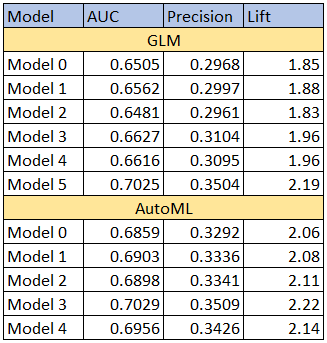